# TRANSFER LEARNING WITH MOBILENETV2

## 1. Importing Libraries

In [1]:
import os
import gc
import random
import shutil
import tarfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import multiprocessing
from tqdm import tqdm
from PIL import Image
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from matplotlib.backends.backend_pdf import PdfPages
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1, l2


## 2. Loading and Preparing Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This code extracts the 102 Flowers Dataset from a .tgz archive, verifies the extracted files, and loads image labels from a .mat file. It then creates a DataFrame (`labels_df`) mapping each image file to its corresponding category.

In [3]:
# Main path
base_path = "/content/drive/My Drive/AML_progetto_2024-2025"
tgz_file_path = os.path.join(base_path, "102flowers.tgz")
extracted_images_dir = "/content/flowers/jpg"

# Excract the .tgz archive
def extract_tgz_file(tgz_path, extract_path):
    if not os.path.exists(extract_path):
        print(f"Extracting {tgz_path}...")
        with tarfile.open(tgz_path, "r:gz") as tar:
            def is_within_directory(directory, target):
                abs_directory = os.path.abspath(directory)
                abs_target = os.path.abspath(target)
                prefix = os.path.commonprefix([abs_directory, abs_target])
                return prefix == abs_directory

            def safe_extract(tar, path=".", members=None, *, numeric_owner=False):
                for member in tar.getmembers():
                    member_path = os.path.join(path, member.name)
                    if not is_within_directory(path, member_path):
                        raise Exception("Attempted Path Traversal in Tar File")
                tar.extractall(path, members, numeric_owner=numeric_owner)

            safe_extract(tar, path=extract_path)
        print(f"Extraction completed. Files are in {extract_path}.")
    else:
        print(f"Directory {extract_path} already exists. Skipping extraction.")

# Extract file if necessary
extract_tgz_file(tgz_file_path, "/content/flowers")

# Verify the right position of the file
if not os.path.exists(extracted_images_dir):
    raise FileNotFoundError(f"Images not found in {extracted_images_dir}. Check extraction path.")

# Load labels in .mat file
matlab_labels = loadmat(os.path.join(base_path, "imagelabels.mat"))
image_labels = matlab_labels['labels'][0]

# Create Dataframe
image_files = sorted([f for f in os.listdir(extracted_images_dir) if f.endswith(".jpg") or f.endswith(".jpeg")])

if len(image_files) != len(image_labels):
    raise ValueError(f"Mismatch between number of images ({len(image_files)}) and labels ({len(image_labels)}).")

labels_df = pd.DataFrame({
    'Image': image_files,
    'Category': image_labels[:len(image_files)]
})
labels_df_aug = labels_df.copy()

Extracting /content/drive/My Drive/AML_progetto_2024-2025/102flowers.tgz...
Extraction completed. Files are in /content/flowers.


## 3. Analize the images that compose the dataset

Loading of the images and of the labels \
Source https://www.robots.ox.ac.uk/~vgg/data/flowers/102/.

In [4]:
!ls "/content/drive/My Drive/AML_progetto_2024-2025/jpg" | head -n 10

image_00001.jpg
image_00002.jpg
image_00003.jpg
image_00004.jpg
image_00005.jpg
image_00006.jpg
image_00007.jpg
image_00008.jpg
image_00009.jpg
image_00010.jpg


Check the presence of all the images

In [5]:
# Add the full path for each image
labels_df['image_path'] = labels_df['Image'].apply(lambda x: os.path.join(extracted_images_dir, x))

# Check if the images exist
labels_df['exists'] = labels_df['image_path'].apply(os.path.exists)

# Statistics on the images
total_images = len(labels_df)
valid_images = labels_df['exists'].sum()
missing_images = total_images - valid_images

print(f"\nTotal number of images: {total_images}")
print(f"Number of valid images: {valid_images}")
print(f"Number of missing images: {missing_images}")



Total number of images: 8189
Number of valid images: 8189
Number of missing images: 0


All images are named as 'image_{ID}.jpg'\
Check for duplicates

In [6]:
# Check for duplicate image IDs in the labels
duplicate_images = labels_df['Image'].duplicated().sum()
if duplicate_images > 0:
    print(f"\nNumber of duplicate image IDs: {duplicate_images}")
    print("Example of duplicates:")
    print(labels_df[labels_df['Image'].duplicated(keep=False)])
else:
    print("\nNo duplicate image IDs found.")



No duplicate image IDs found.


Check for missing labels

In [7]:
# Check for missing labels (if any)
missing_labels = labels_df['Category'].isnull().sum()
if missing_labels > 0:
    print(f"\nNumber of images without labels: {missing_labels}")
    print("Example of missing labels:")
    print(labels_df[labels_df['Category'].isnull()])
else:
    print("\nNo missing labels found.")


No missing labels found.


Check for invalid label values

In [8]:
# Check for invalid label values
unique_labels = labels_df['Category'].unique()
print(f"\nUnique label values: {unique_labels}")




Unique label values: [ 77  73  88  89  81  46  74  51  44  82  83  78  80  75  41  43  76  84
  58  56  86  60  92  11  65   8  23  30  72  53  37  17  12  29  52  18
  36  90  71  40  48  55  85  91  20  47  59   2   5  28  70  22  54  87
  66  32   4  42  13  38  63  68  69  93  14  64  19  49  61  50  15   9
  33  26  25   3  16  79   1  21  24  27  31  34  35  39  67  10  45   6
   7  57  62  94  95  96  97  98  99 100 101 102]


Check for images with invalid formats (e.g., not .jpg)

In [9]:
# Check for images with invalid formats (e.g., not .jpg)
labels_df['extension'] = labels_df['image_path'].apply(lambda x: os.path.splitext(x)[1].lower())
invalid_formats = labels_df[~labels_df['extension'].isin(['.jpg', '.jpeg'])]

if len(invalid_formats) > 0:
    print(f"\nNumber of images with invalid formats: {len(invalid_formats)}")
    print("Example of invalid formats:")
    print(invalid_formats)
else:
    print("\nAll images have valid formats (.jpg or .jpeg).")


All images have valid formats (.jpg or .jpeg).


Count and visualize the distribution of images based on their target values

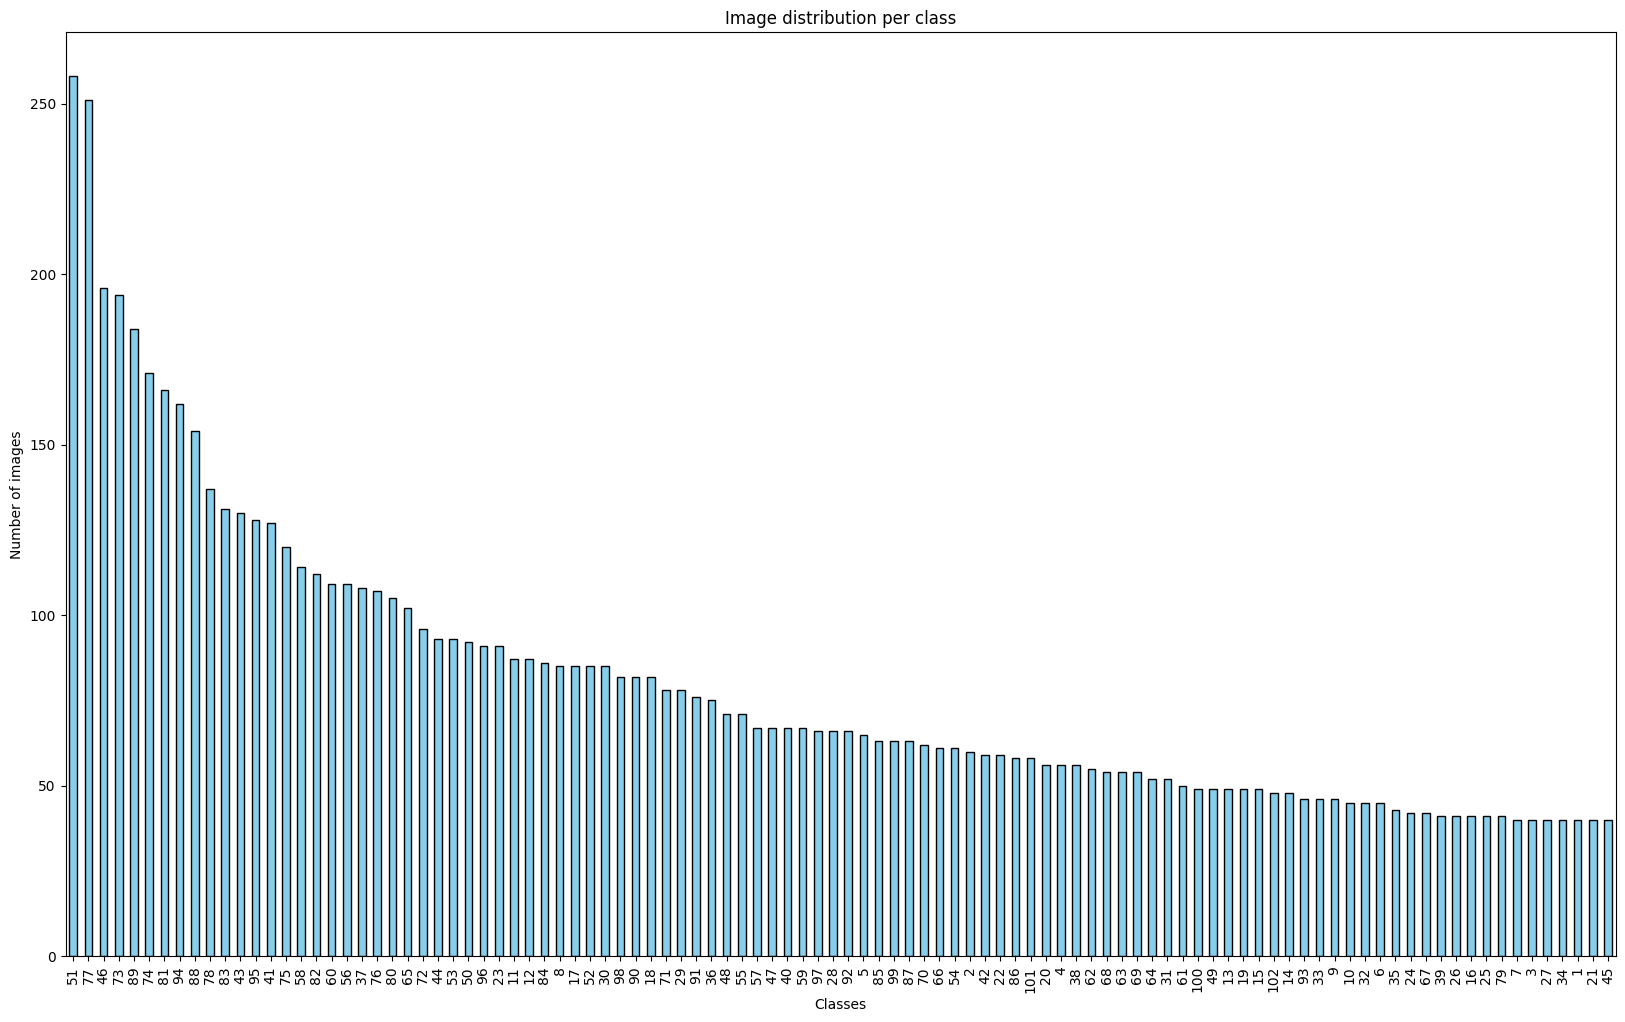

In [10]:
# Count images per class
class_distribution = labels_df['Category'].value_counts()

# Plot the distribution of images per class
plt.figure(figsize=(20, 12))
class_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Image distribution per class")
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.xticks(rotation=90)
plt.show()

Check and identify the most and least represented classes.

In [11]:
#ma and min class rappresentation
max_count = class_distribution.max()
min_count = class_distribution.min()

most_represented_classes = class_distribution[class_distribution == max_count]
least_represented_classes = class_distribution[class_distribution == min_count]

# results
print(f"Classes with the maximum number of images ({max_count}):")
print(most_represented_classes)

print(f"\nClasses with the minimum number of images ({min_count}):")
print(least_represented_classes)


Classes with the maximum number of images (258):
Category
51    258
Name: count, dtype: int64

Classes with the minimum number of images (40):
Category
7     40
3     40
27    40
34    40
1     40
21    40
45    40
Name: count, dtype: int64


Print class frequencies as a percentage of the total

In [12]:
# Compute relative frequencies
relative_frequencies = labels_df['Category'].value_counts(normalize=True) * 100  # Percentage

# Display relative frequencies
relative_frequencies = relative_frequencies.reset_index()
relative_frequencies.columns = ['Category', 'Frequency (%)']
print(relative_frequencies)

     Category  Frequency (%)
0          51       3.150568
1          77       3.065087
2          46       2.393455
3          73       2.369032
4          89       2.246917
..        ...            ...
97         27       0.488460
98         34       0.488460
99          1       0.488460
100        21       0.488460
101        45       0.488460

[102 rows x 2 columns]


In [13]:
# Check if all image paths exist
missing_images = labels_df[~labels_df['exists']]
print(f"Missing images: {len(missing_images)}")
print(missing_images.head())

Missing images: 0
Empty DataFrame
Columns: [Image, Category, image_path, exists, extension]
Index: []


Convert the 'Category' column to numeric, setting non-numeric values to NaN

In [16]:
# Count the number of rows before conversion
num_rows_before = labels_df.shape[0]

# Convert 'Category' to numeric and remove NaN values
labels_df['Category'] = pd.to_numeric(labels_df['Category'], errors='coerce')
labels_df_cleaned = labels_df.dropna(subset=['Category'])  # Removes rows with NaN
labels_df_cleaned['Category'] = labels_df_cleaned['Category'].astype(int)  # Converts to integer

# Count the number of rows after removing NaN values
num_rows_after = labels_df_cleaned.shape[0]

# Print the number of removed rows
num_rows_removed = num_rows_before - num_rows_after
if num_rows_removed > 0:
    print(f" Warning: {num_rows_removed} rows were removed because they contained non-numeric values in 'Category'.")
else:
    print(" No rows were removed: all categories were numeric.")


 No rows were removed: all categories were numeric.


Visualizing sample images for selected classes to quickly inspect dataset


Class 4 has 56 images.


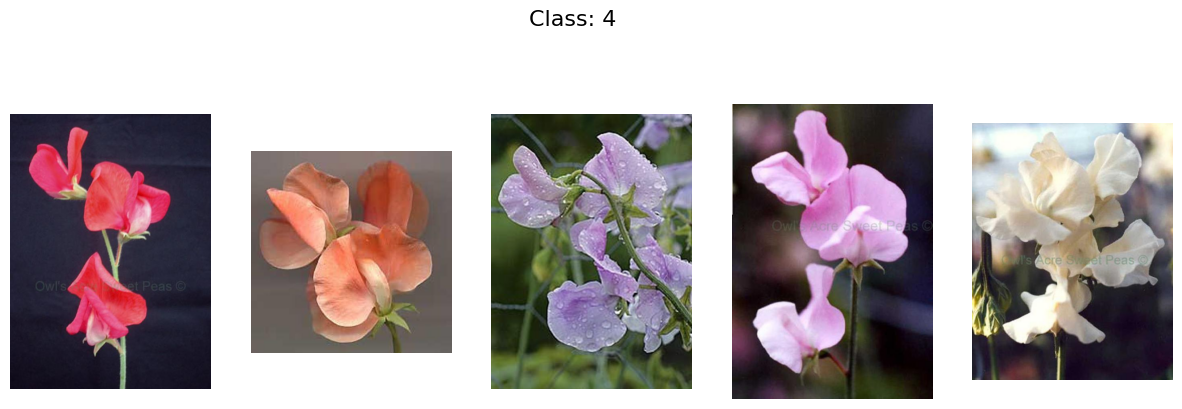


Class 51 has 258 images.


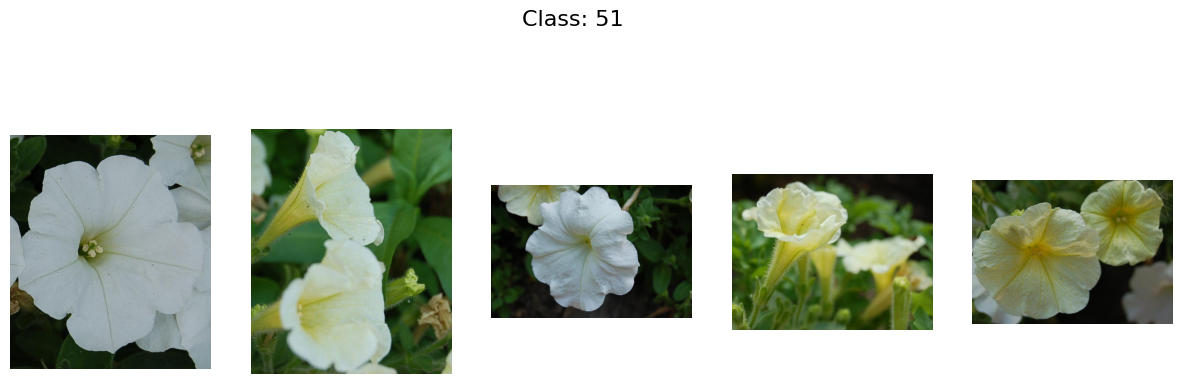


Class 59 has 67 images.


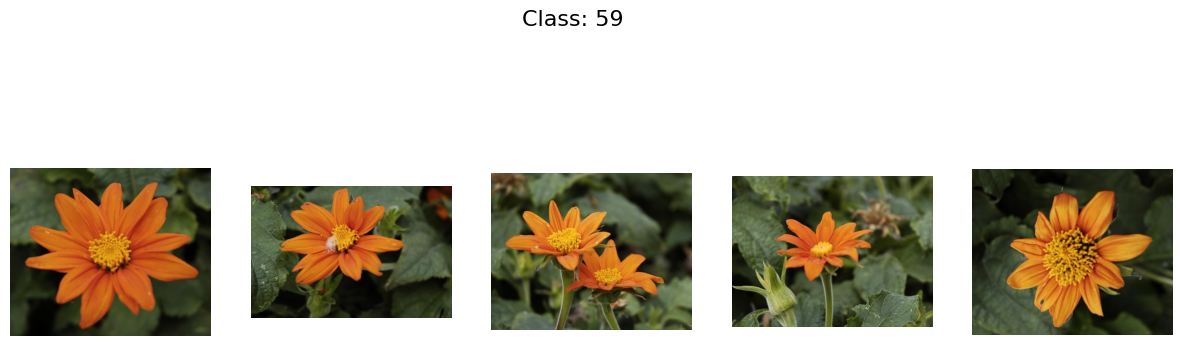


Class 27 has 40 images.


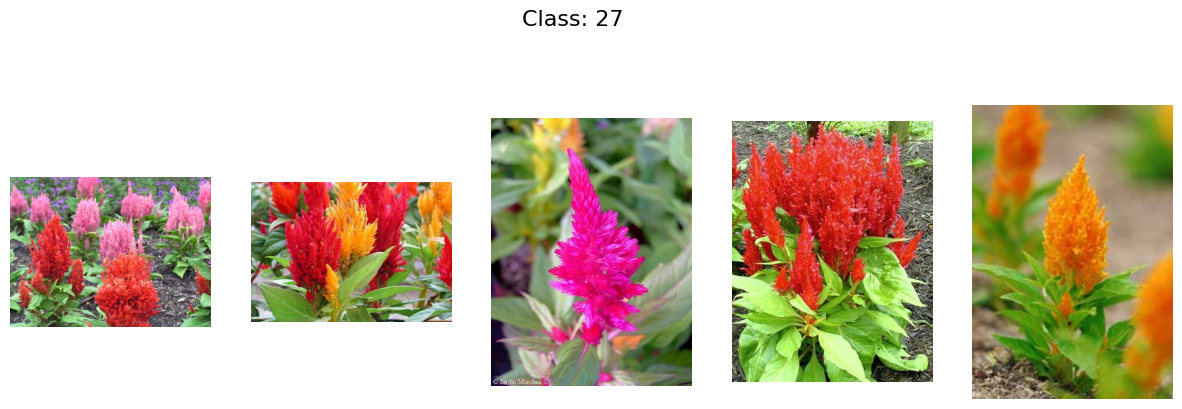


Class 38 has 56 images.


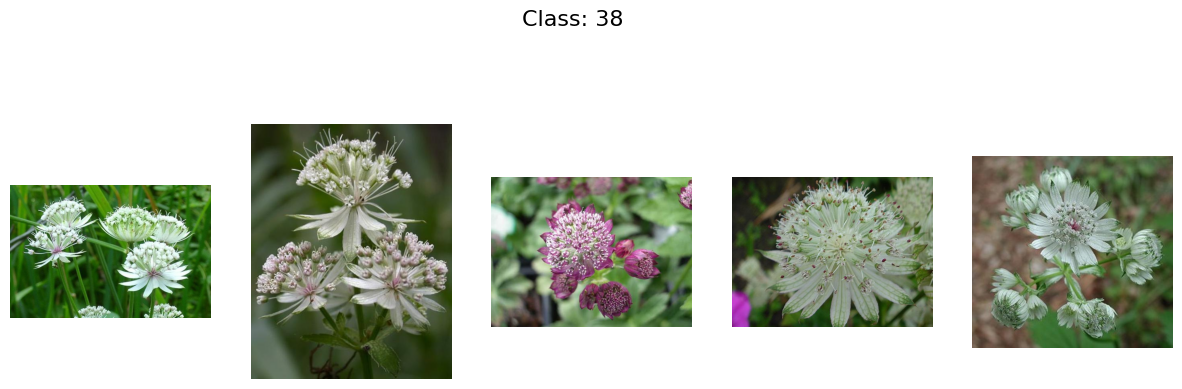


Class 6 has 45 images.


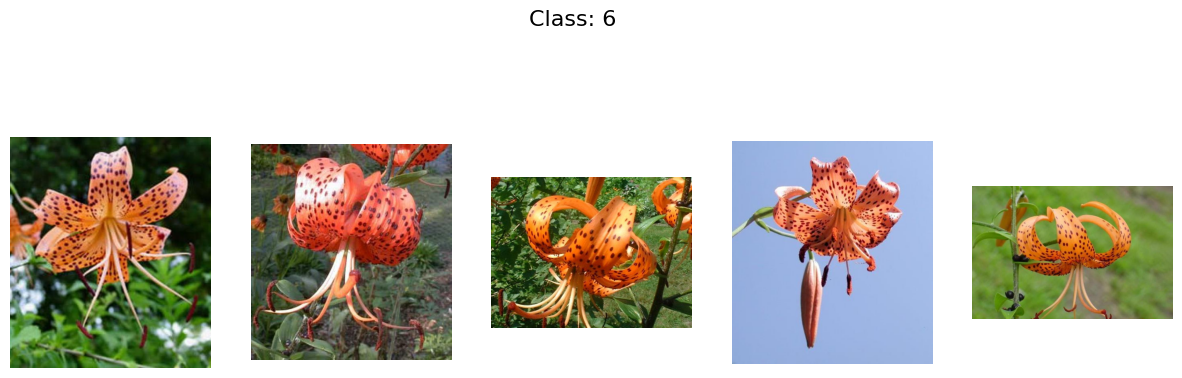


Class 7 has 40 images.


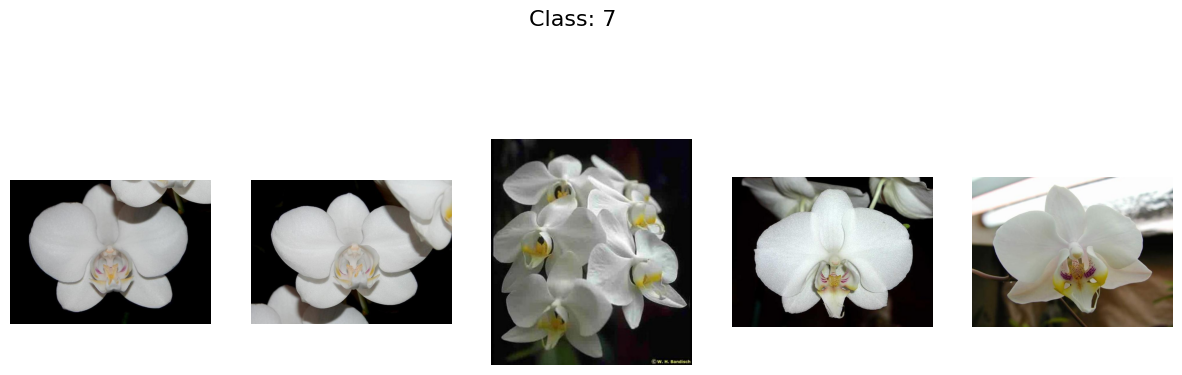


Class 8 has 85 images.


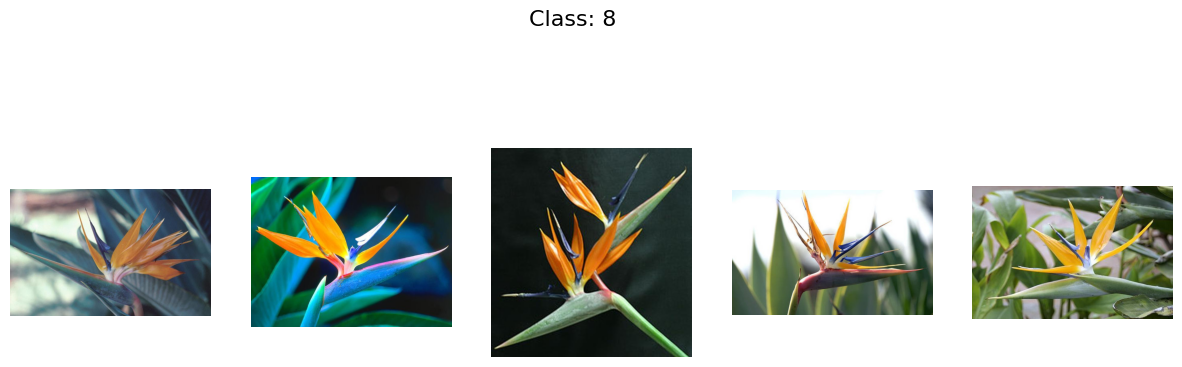

In [15]:
def plot_images_for_classes(classes, labels_df, num_images=5):
    for class_label in classes:
        # Filter the original images of the requested class
        class_images = labels_df[labels_df['Category'] == class_label]['image_path'].values

        # Debug: Number of available images for the class
        print(f"\nClass {class_label} has {len(class_images)} images.")

        if len(class_images) == 0:
            print(f"No images available for class {class_label}.")
            continue

        # Create the plot
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Class: {class_label}", fontsize=16)

        for i, img_path in enumerate(class_images[:num_images]):
            if os.path.exists(img_path):  # Check if the file exists
                plt.subplot(1, num_images, i + 1)
                img = Image.open(img_path)
                plt.imshow(img)
                plt.axis("off")

        plt.show()

# Example usage with original images
classes_to_plot = [4, 51, 59, 27, 38, 6, 7, 8]
plot_images_for_classes(classes_to_plot, labels_df, num_images=5)


## 4. Train, Validation and Test division and Preprocessing Without Data Augmentation



Load image labels, create a dataset with image paths, check file existence, and perform a stratified train-validation-test split

In [139]:
# Image paths and labels
image_paths = labels_df['Image'].apply(lambda x: os.path.join(extracted_images_dir, x)).values
labels_df['Category'] = labels_df['Category'] - 1

# Verify label conversion
print("Unique labels after conversion:", np.unique(labels_df['Category']))
assert labels_df['Category'].min() == 0, "Error: Labels must start from 0!"
assert labels_df['Category'].max() == 101, "Error: Labels must go up to 101!"

# Image paths and labels
image_paths = labels_df['Image'].apply(lambda x: os.path.join(extracted_images_dir, x)).values
labels = labels_df['Category'].values

# Validate the number of classes
num_classes = len(np.unique(labels))
print(f"Total number of classes: {num_classes}")

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))


Unique labels after conversion: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101]
Total number of classes: 102


This code defines the preprocess_image function, which loads, resizes, and normalizes images. It also performs one-hot encoding for the labels.

In [17]:
def preprocess_image(image_path, label):
    # Load and resize the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG
    image = tf.image.resize(image, [224, 224])  # Resize
    image = image / 255.0  # Normalize between 0 and 1

    # One-hot encoding
    label = tf.one_hot(label, depth=num_classes)

    return image, label


Here, the dataset is split into three parts: train, validation, and test.
For each class, 28 images are assigned to the training set, while the remaining images are evenly split between validation and test sets.

In [18]:
# Number of images per class
train_per_class = 28

# Create lists for dataset splits
train_list = []
val_list = []
test_list = []

# Group by category
for category, group in labels_df.groupby("Category"):
    # Shuffle images in the class
    group = group.sample(frac=1, random_state=42).reset_index(drop=True)

    # Take 28 images for training
    train_list.append(group[:train_per_class])

    # Split remaining images into validation and test sets
    remaining = group[train_per_class:]
    val_size = len(remaining) // 2

    val_list.append(remaining[:val_size])
    test_list.append(remaining[val_size:])

# Merge the datasets
train_df = pd.concat(train_list).reset_index(drop=True)
val_df = pd.concat(val_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)


print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")



Train set: 2856 images
Validation set: 2642 images
Test set: 2691 images


This cell generates a bar chart displaying the number of images available per class in the train, validation, and test sets.

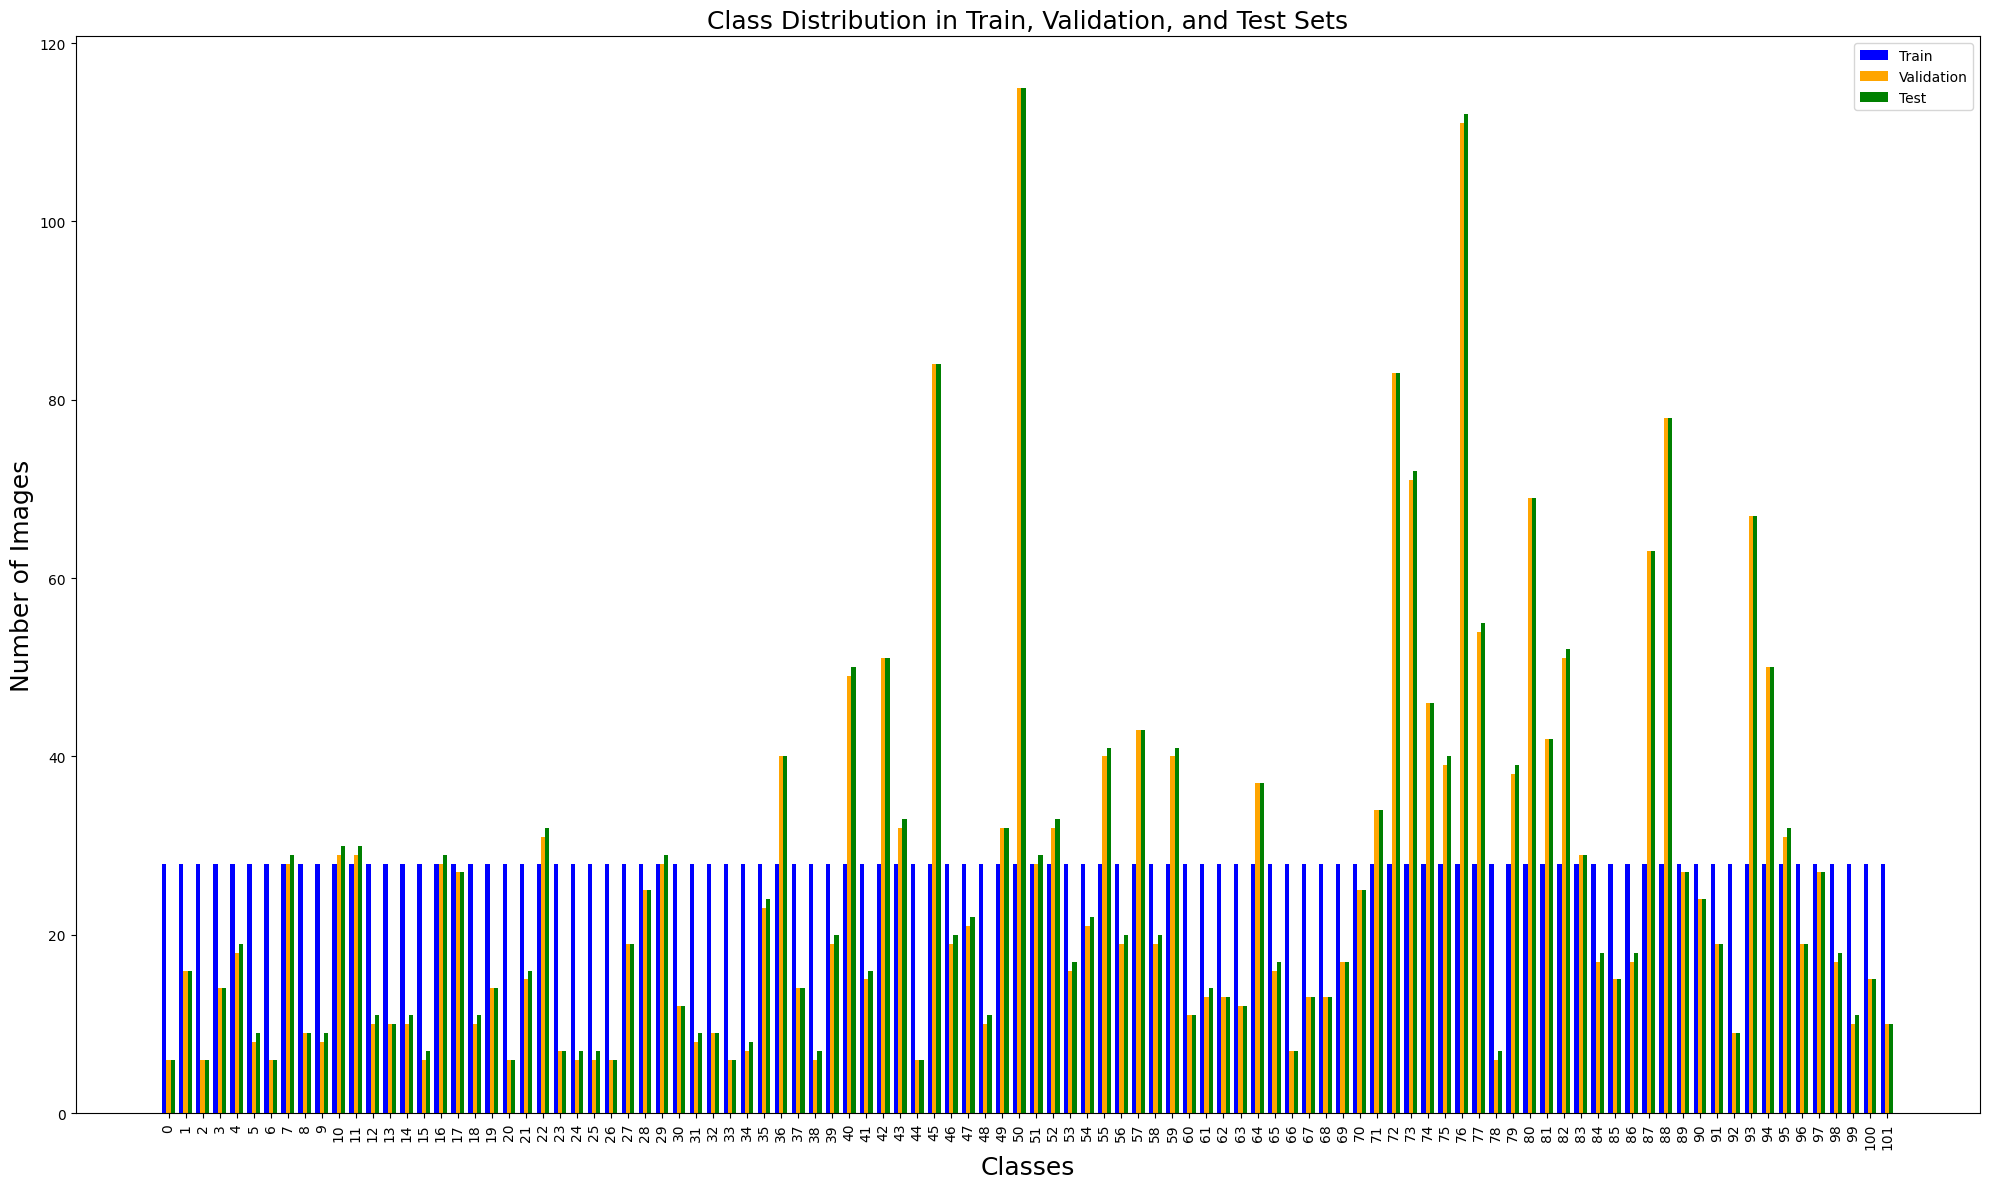

In [19]:
# Visualization of Class Distribution
train_freq = train_df["Category"].value_counts().sort_index()
val_freq = val_df["Category"].value_counts().sort_index()
test_freq = test_df["Category"].value_counts().sort_index()

# Plot the class distribution
plt.figure(figsize=(20, 12))
x = range(len(train_freq.index))
width = 0.25

plt.bar([i - width for i in x], train_freq, width=width, label='Train', color='blue')
plt.bar(x, val_freq, width=width, label='Validation', color='orange')
plt.bar([i + width for i in x], test_freq, width=width, label='Test', color='green')

plt.xlabel("Classes", fontsize=18)
plt.ylabel("Number of Images", fontsize=18)
plt.title("Class Distribution in Train, Validation, and Test Sets", fontsize=18)
plt.xticks(x, train_freq.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

The conversion from a DataFrame to a TensorFlow dataset is particularly efficient because it enables greater efficiency and scalability (using batches) while ensuring seamless integration and optimization with GPUs

In [20]:
# Convert DataFrames into arrays of file paths and labels
def df_to_dataset(df, batch_size=32, shuffle=True):
    image_paths = df["Image"].apply(lambda x: os.path.join(extracted_images_dir, x)).values
    labels = df["Category"].values

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create the datasets
batch_size = 32
train_ds = df_to_dataset(train_df, batch_size=batch_size, shuffle=True)
val_ds = df_to_dataset(val_df, batch_size=batch_size, shuffle=False)
test_ds = df_to_dataset(test_df, batch_size=batch_size, shuffle=False)


This section checks the number of images and unique classes in both the DataFrames and TensorFlow datasets to ensure correct dataset construction.

In [21]:
# Verify the number of images and classes in the DataFrames
def verify_dataframe(df, df_name):
    num_images = len(df)
    unique_classes = df['Category'].nunique()
    print(f"{df_name}:")
    print(f"  Number of images: {num_images}")
    print(f"  Number of unique classes: {unique_classes}")
    print(f"  Unique classes: {sorted(df['Category'].unique())}\n")

# Verify the number of images and classes in the DataStores
def verify_dataset(dataset, dataset_name):
    all_labels = []
    num_images = 0

    # Iterate over the dataset to count samples and extract labels
    for _, labels in dataset.unbatch():
        num_images += 1
        if len(labels.shape) > 0:  # Check if labels are one-hot encoded
            all_labels.append(tf.argmax(labels).numpy())
        else:
            all_labels.append(labels.numpy())  # Scalar labels

    unique_classes = np.unique(all_labels)
    print(f"{dataset_name}:")
    print(f"  Number of images: {num_images}")
    print(f"  Number of unique classes: {len(unique_classes)}")
    print(f"  Unique classes: {sorted(unique_classes)}\n")

# Verify DataFrames
verify_dataframe(train_df, "Train DataFrame")
verify_dataframe(val_df, "Validation DataFrame")
verify_dataframe(test_df, "Test DataFrame")

# Verify TensorFlow Datasets
verify_dataset(train_ds, "Train Dataset")
verify_dataset(val_ds, "Validation Dataset")
verify_dataset(test_ds, "Test Dataset")



Train DataFrame:
  Number of images: 2856
  Number of unique classes: 102
  Unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]

Validation DataFrame:
  Number of images: 2642
  Number of unique classes: 102
  Unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]

Test Da

This particular test set is designed to evaluate the performance of the model using an equal number of samples for each class. The basic test set is composed of a high number of samples of the most represented classes, making it difficult to fairly evaluate performance across all classes

In [83]:
#create a test set with 6 images for each class
im_per_class = 6
test_list_equalsize = []

for category, group in test_df.groupby("Category"):
    selected_images = group.sample(n=im_per_class, random_state=42)
    test_list_equalsize.append(selected_images)

test_df_equalsize = pd.concat(test_list_equalsize).reset_index(drop=True)

print(f"New test set equal-size: {len(test_df_equalsize)} images")

New test set equal-size: 612 images


In [23]:
# Ensure that each category has exactly 6 images
print(test_df_equalsize.groupby("Category").size())

# Verify some rows to ensure that labels are correct
print(test_df_equalsize[12:32])

#create the dataset for the equal-sized test set:
test_ds_equalsize = df_to_dataset(test_df_equalsize, batch_size=batch_size, shuffle=True)

Category
0      6
1      6
2      6
3      6
4      6
      ..
97     6
98     6
99     6
100    6
101    6
Length: 102, dtype: int64
              Image  Category                            image_path  exists  \
12  image_06630.jpg         2  /content/flowers/jpg/image_06630.jpg    True   
13  image_06632.jpg         2  /content/flowers/jpg/image_06632.jpg    True   
14  image_06650.jpg         2  /content/flowers/jpg/image_06650.jpg    True   
15  image_06619.jpg         2  /content/flowers/jpg/image_06619.jpg    True   
16  image_06640.jpg         2  /content/flowers/jpg/image_06640.jpg    True   
17  image_06626.jpg         2  /content/flowers/jpg/image_06626.jpg    True   
18  image_05671.jpg         3  /content/flowers/jpg/image_05671.jpg    True   
19  image_05657.jpg         3  /content/flowers/jpg/image_05657.jpg    True   
20  image_05664.jpg         3  /content/flowers/jpg/image_05664.jpg    True   
21  image_05680.jpg         3  /content/flowers/jpg/image_05680.jpg    True 

In [24]:
#del labels_df, train_df, val_df, test_df
#gc.collect()


## 5. Defining Model Without Data Augmentation

### 5.1 Simple MobileNetV2

This model is based on MobileNetV2, a lightweight convolutional neural network (CNN) pre-trained on the ImageNet dataset.


*   The pretrained MobileNetV2 is loaded without the top classification layer (include_top=False), keeping only the feature extraction layers.
*   VocGlobalAveragePooling2D: Reduces the spatial dimensions, converting feature maps into a single vector per image.
*   Dense Layer (Softmax Activation): Fully connected output layer with num_classes neurons (one for each class in the dataset), applying softmax activation for multi-class classification.
*   Optimizer: Adam(learning_rate=1e-3): Adaptive learning rate optimizer for efficient weight updates.
*   Loss Function: categorical_crossentropy: Suitable for multi-class classification.






In [25]:
# Pretrained model (MobileNetV2)
pretrained_layer = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                      include_top=False,
                                                      weights='imagenet')
pretrained_layer.trainable = False  # Freeze the pretrained layers

# Add custom layers
model = tf.keras.Sequential([
    pretrained_layer,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

# Print model summary
model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 102)                 │         130,662 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,388,646 (9.11 MB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

The model is trained for 20 epochs and early stopping is used (patience=5), stopping training if validation loss does not improve for 5 consecutive epochs

In [26]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopping],
)


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 189ms/step - accuracy: 0.1713 - loss: 4.2187 - val_accuracy: 0.5556 - val_loss: 2.1563
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7419 - loss: 1.4235 - val_accuracy: 0.7313 - val_loss: 1.2793
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8808 - loss: 0.7354 - val_accuracy: 0.7763 - val_loss: 1.0390
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9302 - loss: 0.4985 - val_accuracy: 0.8077 - val_loss: 0.8376
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9587 - loss: 0.3456 - val_accuracy: 0.8270 - val_loss: 0.7323
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9814 - loss: 0.2335 - val_accuracy: 0.8236 - val_loss: 0.6932
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9820 - loss: 0.1945 - val_accuracy: 0.8308 - val_loss: 0.6686
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9950 - loss: 0.1482 - val_accuracy: 0.8255 -

The trained model is evaluated on:

Test dataset (`test_ds`): Overall accuracy measurement.

Balanced test dataset (`test_ds_equalsize`): Evaluates model performance with equal class representation (6 images per class).

In [27]:
# Accuracy on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

#Calculate accuracy on the balanced test-set with 6 samples per class
test_loss, test_accuracy_equalsize = model.evaluate(test_ds_equalsize)
print(f"Test Accuracy (on balanced test set): {test_accuracy_equalsize * 100:.2f}%")


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8510 - loss: 0.5542
Test Accuracy: 85.95%
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.8500 - loss: 0.5262
Test Accuracy (on balanced test set): 86.60%


The model is saved in a h5 format

In [28]:
#  Save the model
model.save("model_oxford102.h5")

#### 5.1.1. Plotting train and validation accuracy/loss

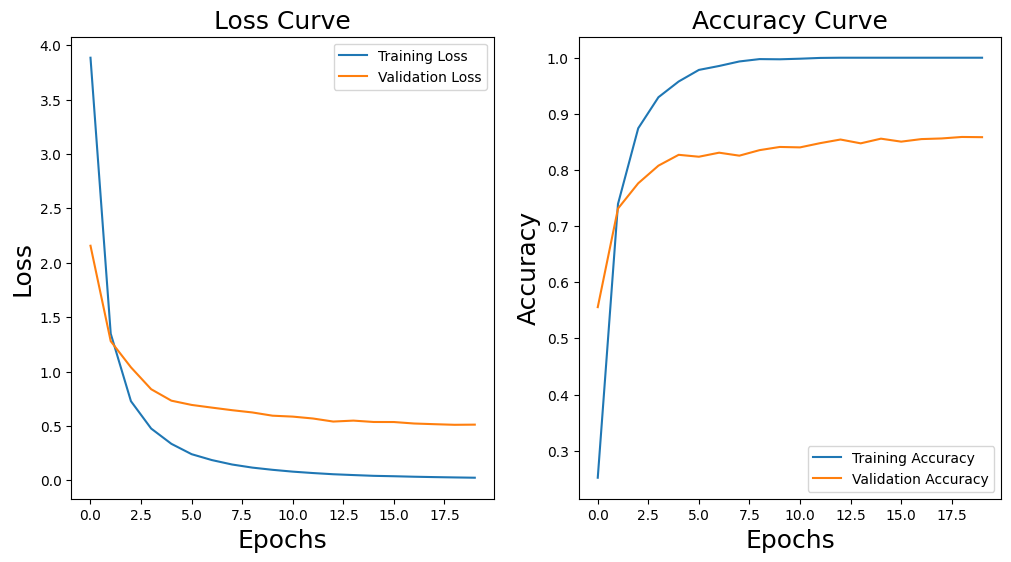

In [133]:
plt.figure(figsize=(12, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend()

# Save the plot
plt.savefig("history_training_mobnetV1.pdf")

# Show the plot
plt.show()



**Loss Curve**  

Training Loss: The training loss decreases rapidly over the epochs, indicating the model is learning effectively from the training data.

Validation Loss: The validation loss decreases initially, stabilizing toward the later epochs. The gap between training and validation loss suggests a very high overfitting.

 **Accuracy Curve**

Training Accuracy: Increases quickly and plateaus close to 100%, showing the model's excellent performance on the training set.

Validation Accuracy: Improves consistently, stabilizing around 99%. The gap between training and validation accuracy indicates that the model has significant difficulty generalizing to unseen data, leading to high overfitting.


#### 5.1.2. Confusion Matrix

This code computes and visualizes the confusion matrix for the base model, showing its performance across all classes. Additionally, it generates a classification report and calculates the overall accuracy, highlighting any missing classes in predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━

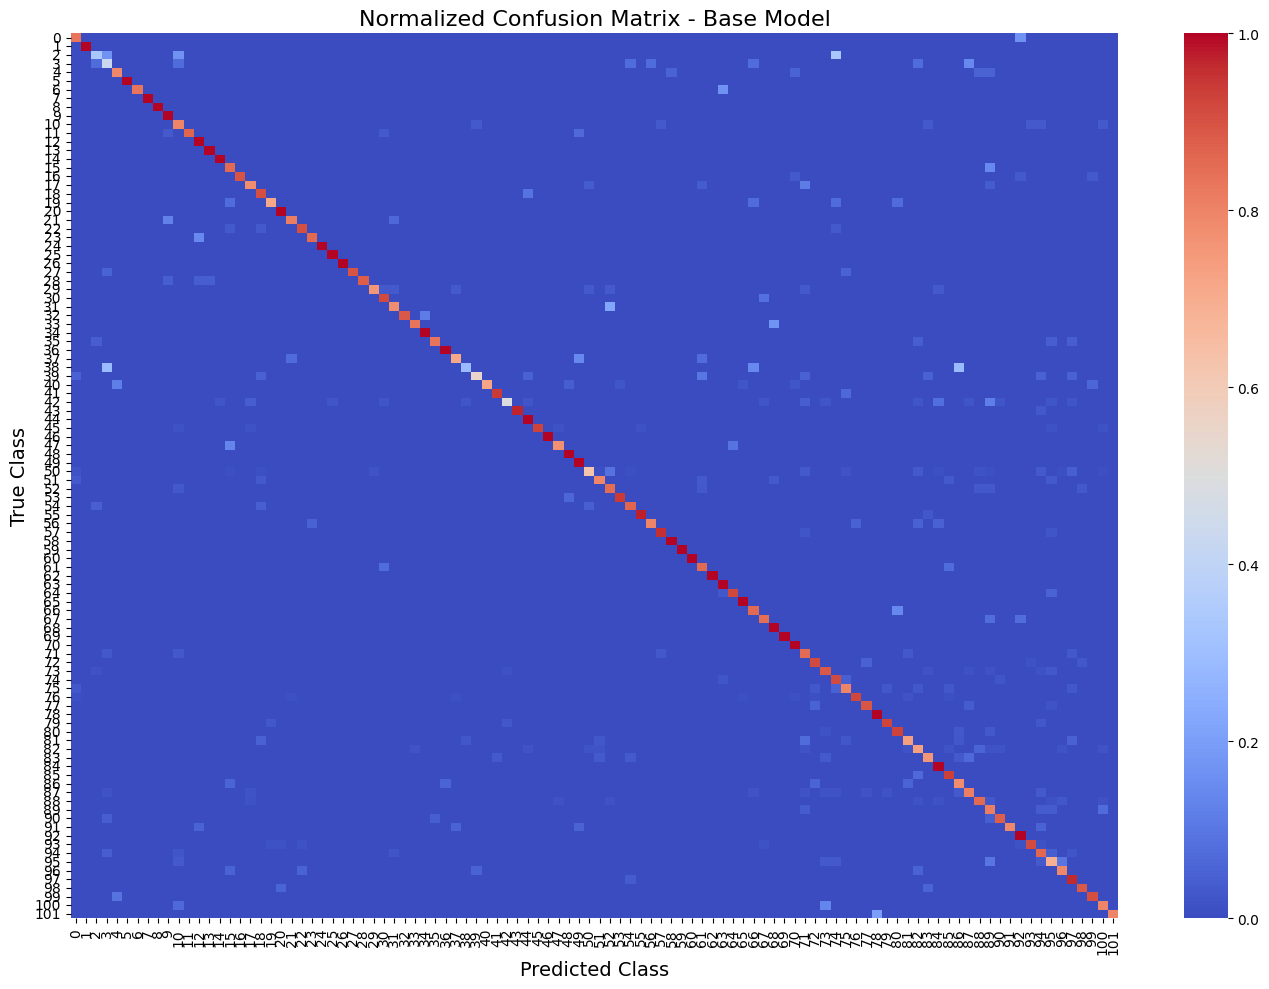

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.45      0.83      0.59         6
     Class 1       1.00      1.00      1.00        16
     Class 2       0.33      0.33      0.33         6
     Class 3       0.40      0.43      0.41        14
     Class 4       0.68      0.79      0.73        19
     Class 5       1.00      1.00      1.00         9
     Class 6       1.00      0.83      0.91         6
     Class 7       1.00      1.00      1.00        29
     Class 8       1.00      1.00      1.00         9
     Class 9       0.69      1.00      0.82         9
    Class 10       0.75      0.80      0.77        30
    Class 11       1.00      0.87      0.93        30
    Class 12       0.79      1.00      0.88        11
    Class 13       0.91      1.00      0.95        10
    Class 14       0.92      1.00      0.96        11
    Class 15       0.43      0.86      0.57         7
    Class 16       1.00      0.90      0.95        29
    

In [30]:
# Compute predictions and true labels
y_true, y_pred = [], []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Convert lists to numpy arrays
y_true, y_pred = np.array(y_true), np.array(y_pred)

# Check unique classes in true labels and predictions
print("Unique classes in test data:", np.unique(y_true))
print("Unique classes in predictions:", np.unique(y_pred))
print(f"Total defined classes: {num_classes}")

# Generate Confusion Matrix
unique_classes = np.unique(y_true.tolist() + y_pred.tolist())
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix with seaborn heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cm_normalized, annot=False, cmap="coolwarm", cbar=True, xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)
plt.title("Normalized Confusion Matrix - Base Model", fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("confusion_matrix_base_model.pdf")
plt.show()

# Generate Classification Report
report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in unique_classes])
print("Classification Report:")
print(report)

# Compute Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}")

# Check for missing classes in predictions
missing_classes = set(range(num_classes)) - set(np.unique(y_pred))
if missing_classes:
    print(f"Warning: The following classes were never predicted by the model: {missing_classes}")



In [31]:
#QUESTA PER SALVARE MODELLO E HISTORY

# Salva il modello in una directory di Google Drive
#model.save('/content/drive/My Drive/mobilenetv2_custom_model.h5')
# Carica il modello salvato da Google Drive
#model = tf.keras.models.load_model('/content/drive/My Drive/mobilenetv2_custom_model.h5')
#import json

# Salva la storia in un file JSON
#with open('history.json', 'w') as f:
#    json.dump(history.history, f)

### 5.2 MobileNetV2  with regularization

 To try to reduce overfitting in this model, we will only add a dropout layer (40%) before passing the output to a fully connected Dense layer with num_classes units, using a softmax activation for multi-class classification. All the other parameter remain unchanged except for the number of epochs, which has been increased to 30 to allow the model to learn more complex patterns while still monitoring validation loss.

In [32]:
model_reg_1 = tf.keras.Sequential([
    pretrained_layer,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(num_classes,
                 activation='softmax')
])

model_reg_1.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.1
)

model_reg_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 102)                 │         130,662 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,388,646 (9.11 MB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
history_reg_1 = model_reg_1.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.0081 - loss: 5.2411 - val_accuracy: 0.0326 - val_loss: 4.5847
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.0438 - loss: 4.4507 - val_accuracy: 0.1071 - val_loss: 4.0372
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.0971 - loss: 3.9709 - val_accuracy: 0.2256 - val_loss: 3.6378
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.1549 - loss: 3.6214 - val_accuracy: 0.3448 - val_loss: 3.2954
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.2622 - loss: 3.2462 - val_accuracy: 0.4387 - val_loss: 2.9993
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.3473 - loss: 2.9012 - val_accuracy: 0.5151 - val_loss: 2.7412
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.4119 - loss: 2.6323 - val_accuracy: 0.5765 - val_loss: 2.5200
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.4894 - loss: 2.3790 - val_accuracy: 0.6147 -

In [34]:
# Accuracy on test set
test_loss, test_accuracy = model_reg_1.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

#Calculate accuracy on the balanced test-set with 6 samples per class
test_loss, test_accuracy_equalsize = model_reg_1.evaluate(test_ds_equalsize)
print(f"Test Accuracy (on balanced test set): {test_accuracy_equalsize * 100:.2f}%")

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8143 - loss: 0.9731
Test Accuracy: 81.23%
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.8485 - loss: 0.9158
Test Accuracy (on balanced test set): 82.35%


In [35]:
#  Save the model
model_reg_1.save("model_reg_1_oxford102.h5")

##### 5.2.1. Plotting train and validation accuracy/loss

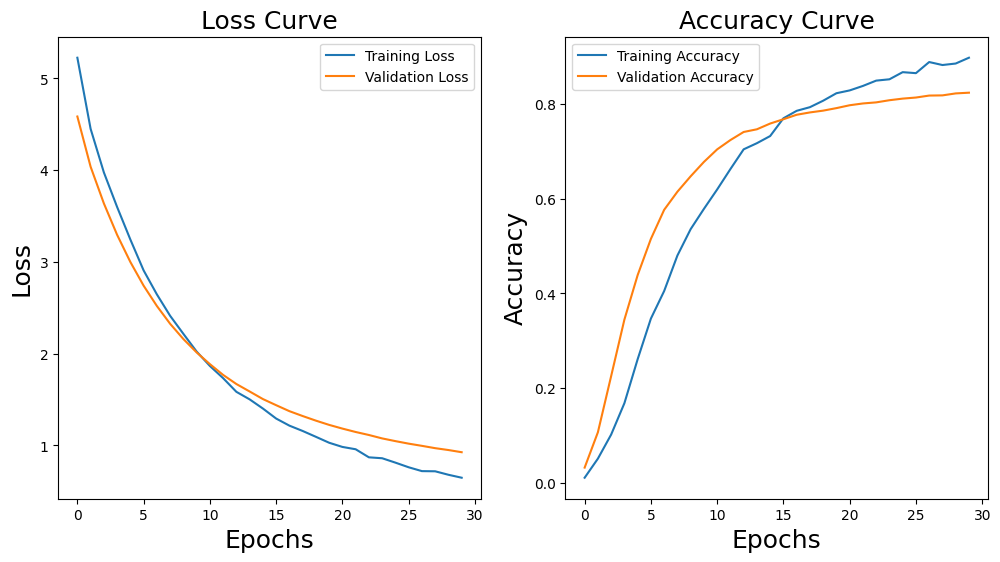

In [134]:
plt.figure(figsize=(12, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history_reg_1.history['loss'], label='Training Loss')
plt.plot(history_reg_1.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history_reg_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_reg_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend()

# Save the plot
plt.savefig("history_training_mobnetV2.pdf")

# Show the plot
plt.show()


**Loss Curve**


Training Loss: The training loss decreases smoothly, reflecting a more controlled learning process due to regularization from dropout.

Validation Loss: The validation loss decreases steadily and stabilizes closer to the training loss, indicating reduced overfitting and improved generalization.

**Accuracy Curve**



Training Accuracy: The training accuracy increases at a more gradual rate and stabilizes, reflecting the regularizing effect of dropout.

Validation Accuracy: The validation accuracy improves steadily, and the smaller gap between training and validation accuracy demonstrates better generalization to unseen data; there is still some overfitting, although to a lesser extent compared to the model without dropout indicating that the dropout has significantly reduced overfitting, improving the model's ability to generalize to unseen data..


##### 5.2.2. Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━

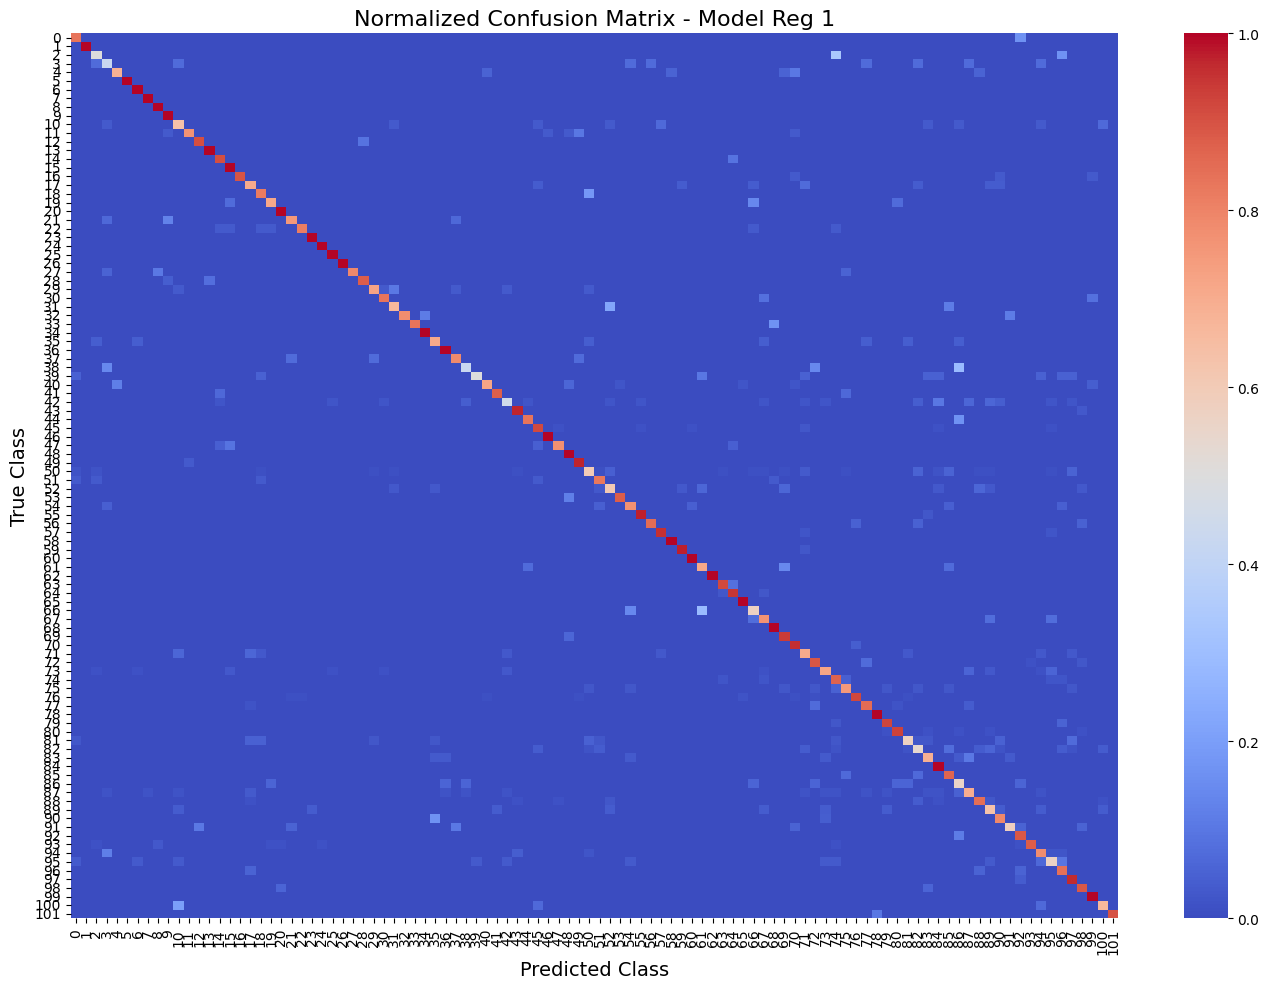

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.45      0.83      0.59         6
     Class 1       1.00      1.00      1.00        16
     Class 2       0.30      0.50      0.38         6
     Class 3       0.33      0.43      0.38        14
     Class 4       0.68      0.68      0.68        19
     Class 5       1.00      1.00      1.00         9
     Class 6       0.67      1.00      0.80         6
     Class 7       0.97      1.00      0.98        29
     Class 8       0.69      1.00      0.82         9
     Class 9       0.69      1.00      0.82         9
    Class 10       0.66      0.63      0.64        30
    Class 11       0.96      0.77      0.85        30
    Class 12       0.83      0.91      0.87        11
    Class 13       0.83      1.00      0.91        10
    Class 14       0.71      0.91      0.80        11
    Class 15       0.54      1.00      0.70         7
    Class 16       1.00      0.90      0.95        29
    

In [37]:
# Compute predictions and true labels for model_reg_1
y_true, y_pred = [], []

for images, labels in test_ds:
    preds = model_reg_1.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true, y_pred = np.array(y_true), np.array(y_pred)

# Check unique classes in true labels and predictions
print("Unique classes in test data:", np.unique(y_true))
print("Unique classes in predictions:", np.unique(y_pred))
print(f"Total defined classes: {num_classes}")

# Generate Confusion Matrix
unique_classes = np.unique(y_true.tolist() + y_pred.tolist())
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
plt.figure(figsize=(14, 10))
sns.heatmap(cm_normalized, annot=False, cmap="coolwarm", cbar=True, xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)
plt.title("Normalized Confusion Matrix - Model Reg 1", fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("confusion_matrix_model_reg_1.pdf")
plt.show()

# Generate Classification Report
report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in unique_classes])
print("Classification Report:")
print(report)

# Compute Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}")

# Check for missing classes in predictions
missing_classes = set(range(num_classes)) - set(np.unique(y_pred))
if missing_classes:
    print(f"Warning: The following classes were never predicted by the model: {missing_classes}")

### 5.3 MobileNetV2  with regularization

The model `model_reg_2` builds on the previous architecture (`model_reg_1`) by incorporating additional layers and techniques to enhance performance and reduce overfitting. After the GlobalAveragePooling2D layer, batch normalization is applied to stabilize training and improve convergence. A dense layer with 128 neurons and ReLU activation is added, alongside L2 regularization (factor 0.02), which helps reduce overfitting by penalizing large weights.
Dropout layers are introduced more aggressively: a 0.3 dropout follows the pooling layer, and a 0.2 dropout follows the dense layer, further minimizing overfitting.

In [38]:
model_reg_2 = tf.keras.Sequential([
    pretrained_layer,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.02)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes,
                 activation='softmax',
                 kernel_regularizer=l2(0.02))
])

model_reg_2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.1
)

model_reg_2.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 102)                 │          13,158 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,440,742 (9.31 MB)

 Trainable params: 179,942 (702.90 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

In [39]:
history_reg_2 = model_reg_2.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stopping]
)



Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 154ms/step - accuracy: 0.0072 - loss: 12.0668 - val_accuracy: 0.0363 - val_loss: 11.0441
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.0386 - loss: 11.0621 - val_accuracy: 0.1188 - val_loss: 10.4149
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1094 - loss: 10.2035 - val_accuracy: 0.2123 - val_loss: 9.8043
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.2129 - loss: 9.5792 - val_accuracy: 0.3073 - val_loss: 9.2339
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.2928 - loss: 9.0073 - val_accuracy: 0.3842 - val_loss: 8.7281
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.3889 - loss: 8.4740 - val_accuracy: 0.4463 - val_loss: 8.2892
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.4449 - loss: 8.0370 - val_accuracy: 0.4989 - val_loss: 7.8818
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5139 - loss: 7.6024 - val_accuracy: 0.5

In [40]:
# Accuracy on test set
test_loss, test_accuracy = model_reg_2.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

#Calculate accuracy on the balanced test-set with 6 samples per class
test_loss, test_accuracy_equalsize = model_reg_2.evaluate(test_ds_equalsize)
print(f"Test Accuracy (on balanced test set): {test_accuracy_equalsize * 100:.2f}%")


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8192 - loss: 3.3358
Test Accuracy: 82.91%
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.8628 - loss: 3.2572
Test Accuracy (on balanced test set): 83.82%


In [41]:
#  Save the model
model_reg_2.save("model_reg_2_oxford102.h5")

##### 5.3.1. Plotting train and validation accuracy/loss

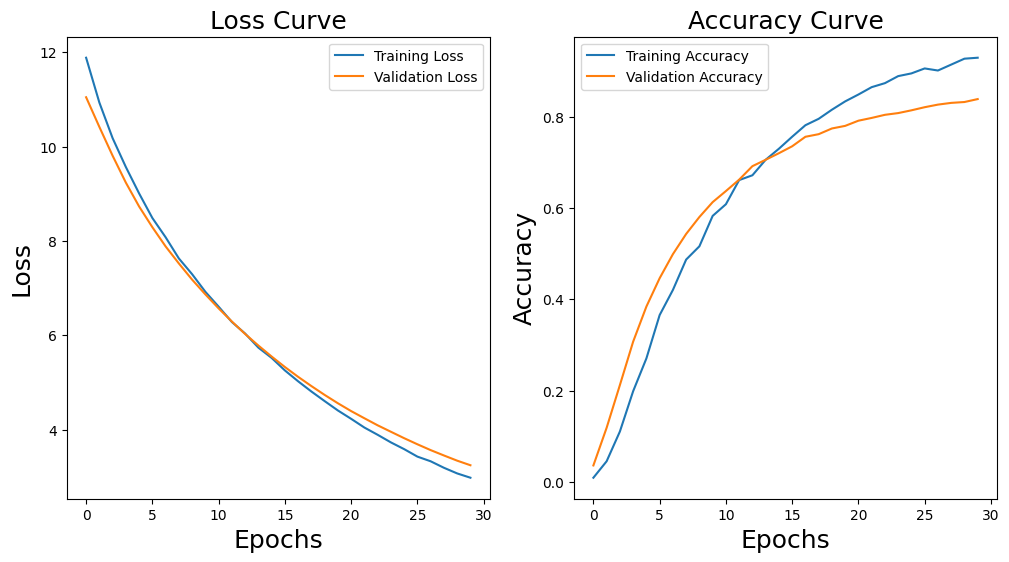

In [135]:
plt.figure(figsize=(12, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history_reg_2.history['loss'], label='Training Loss')
plt.plot(history_reg_2.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history_reg_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_reg_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend()

# Save the plot
plt.savefig("history_training_mobnetV3.pdf")

# Show the plot
plt.show()


**Loss Curve**

Training Loss: The training loss decreases steadily throughout the epochs, indicating that the model effectively minimizes errors on the training set.


Validation Loss: The validation loss also decreases consistently and follows a trajectory similar to the training loss, which suggests that overfitting is minimal and styart in the final epochs.

**Accuracy Curve**

Training Accuracy: The training accuracy increases progressively, eventually stabilizing at a high value, demonstrating the model's strong performance on the training data.

Validation Accuracy: The validation accuracy improves in parallel with the training accuracy, with only a slight gap between the two. This indicates that the model is generalizing in a better way to unseen data, with some overfitting in the last epochs.

##### 5.3.2. Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━

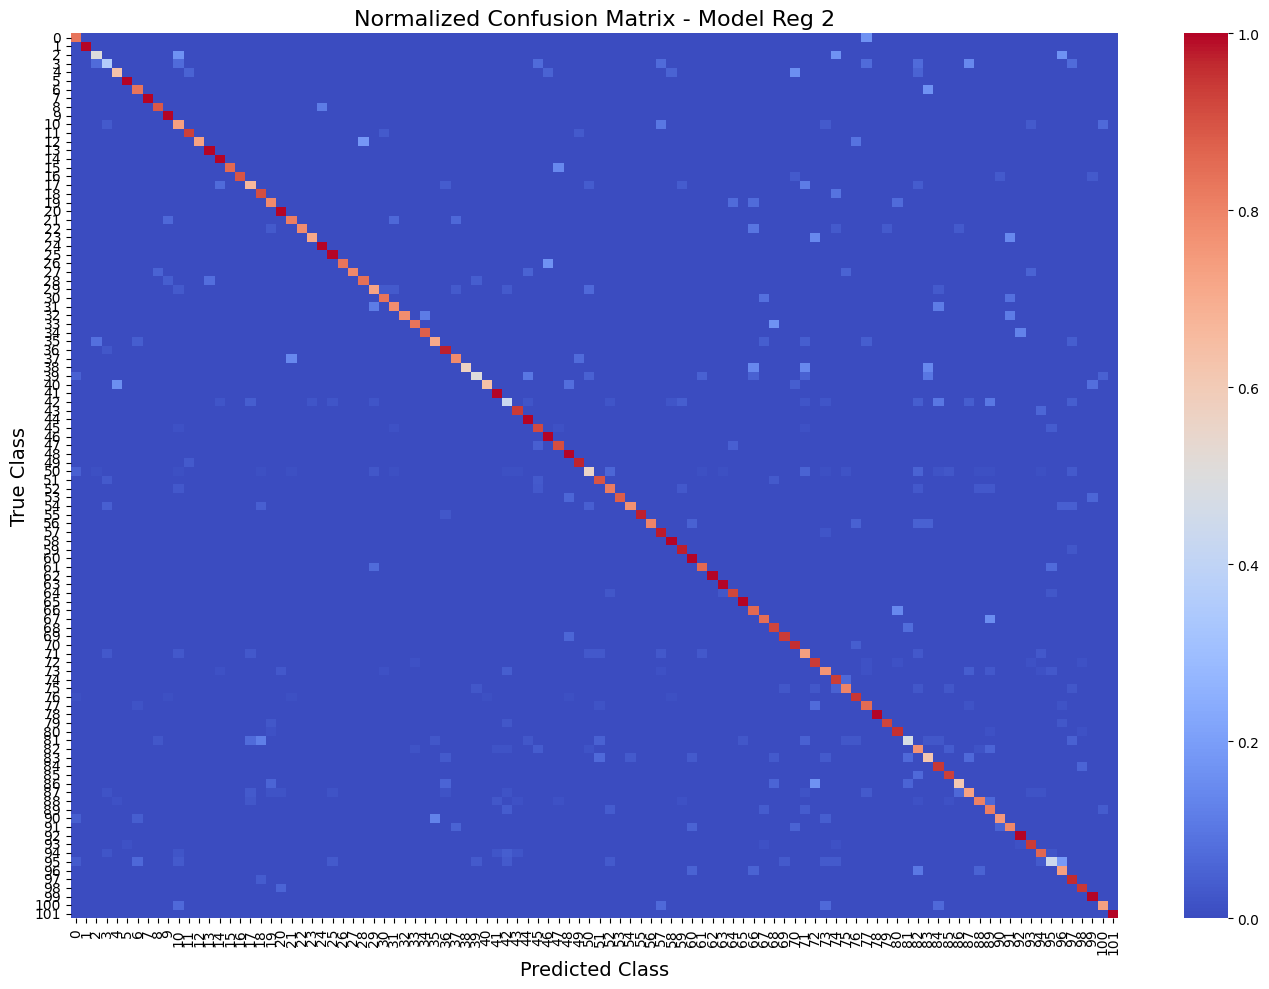

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.36      0.83      0.50         6
     Class 1       1.00      1.00      1.00        16
     Class 2       0.43      0.50      0.46         6
     Class 3       0.42      0.36      0.38        14
     Class 4       0.57      0.63      0.60        19
     Class 5       0.90      1.00      0.95         9
     Class 6       0.50      0.83      0.62         6
     Class 7       1.00      1.00      1.00        29
     Class 8       0.80      0.89      0.84         9
     Class 9       0.75      1.00      0.86         9
    Class 10       0.69      0.73      0.71        30
    Class 11       0.93      0.93      0.93        30
    Class 12       1.00      0.73      0.84        11
    Class 13       0.83      1.00      0.91        10
    Class 14       0.73      1.00      0.85        11
    Class 15       1.00      0.86      0.92         7
    Class 16       1.00      0.90      0.95        29
    

In [43]:
# Compute predictions and true labels for model_reg_2
y_true, y_pred = [], []

for images, labels in test_ds:
    preds = model_reg_2.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true, y_pred = np.array(y_true), np.array(y_pred)

# Check unique classes in true labels and predictions
print("Unique classes in test data:", np.unique(y_true))
print("Unique classes in predictions:", np.unique(y_pred))
print(f"Total defined classes: {num_classes}")

# Generate Confusion Matrix
unique_classes = np.unique(y_true.tolist() + y_pred.tolist())
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
plt.figure(figsize=(14, 10))
sns.heatmap(cm_normalized, annot=False, cmap="coolwarm", cbar=True, xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)
plt.title("Normalized Confusion Matrix - Model Reg 2", fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("confusion_matrix_model_reg_2.pdf")
plt.show()

# Generate Classification Report
report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in unique_classes])
print("Classification Report:")
print(report)

# Compute Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}")

# Check for missing classes in predictions
missing_classes = set(range(num_classes)) - set(np.unique(y_pred))
if missing_classes:
    print(f"Warning: The following classes were never predicted by the model: {missing_classes}")


### 5.4 MobileNetV2  with regularization

In this model we apply the tuning of some parameter like dropout and L2 to reduce the overfitting.

In [126]:
model_reg_3 = tf.keras.Sequential([
    pretrained_layer,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.03)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes,
                 activation='softmax',
                 kernel_regularizer=l2(0.03))
])

model_reg_3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.001
)

model_reg_3.summary()


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_23          │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 102)                 │          13,158 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,440,742 (9.31 MB)

 Trainable params: 179,942 (702.90 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

In [127]:
history_reg_3 = model_reg_3.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.0099 - loss: 15.4066 - val_accuracy: 0.0435 - val_loss: 14.1872
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.0335 - loss: 14.2953 - val_accuracy: 0.1257 - val_loss: 13.3268
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.0787 - loss: 13.2353 - val_accuracy: 0.2188 - val_loss: 12.4940
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1464 - loss: 12.3847 - val_accuracy: 0.2918 - val_loss: 11.7229
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.2039 - loss: 11.6646 - val_accuracy: 0.3698 - val_loss: 11.0158
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.2758 - loss: 10.9111 - val_accuracy: 0.4296 - val_loss: 10.3836
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.3316 - loss: 10.2970 - val_accuracy: 0.4841 - val_loss: 9.8006
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.3827 - loss: 9.6907 - val_accur

In [128]:
# Accuracy on test set
test_loss, test_accuracy = model_reg_3.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

#Calculate accuracy on the balanced test-set with 6 samples per class
test_loss, test_accuracy_equalsize = model_reg_3.evaluate(test_ds_equalsize)
print(f"Test Accuracy (on balanced test set): {test_accuracy_equalsize * 100:.2f}%")


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8153 - loss: 3.4843
Test Accuracy: 81.79%
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.8328 - loss: 3.4163
Test Accuracy (on balanced test set): 81.86%


In [47]:
#  Save the model
model_reg_3.save("model_reg_3_oxford102.h5")

##### 5.4.1. Plotting train and validation accuracy/loss

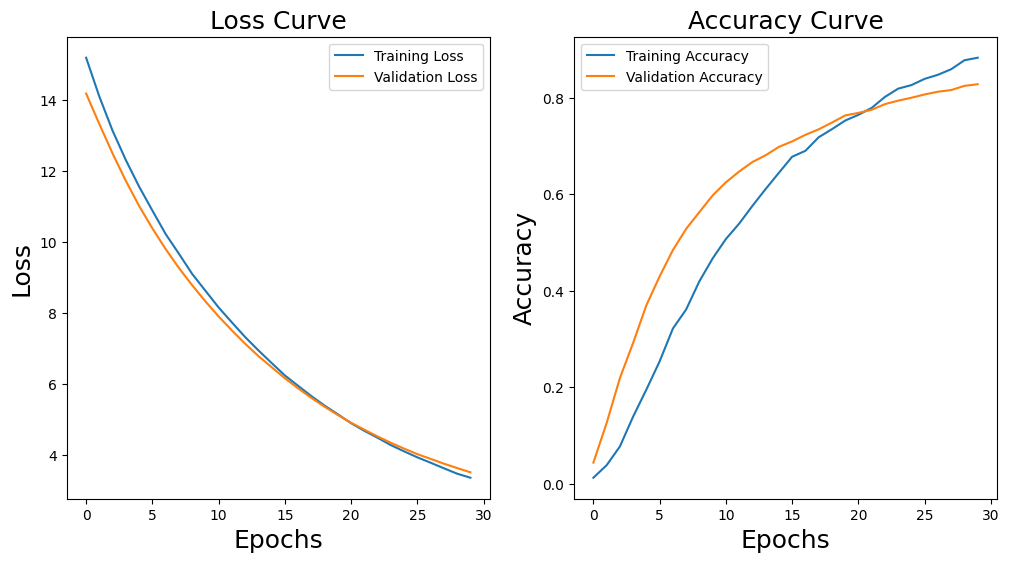

In [136]:
plt.figure(figsize=(12, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history_reg_3.history['loss'], label='Training Loss')
plt.plot(history_reg_3.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history_reg_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_reg_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend()

# Save the plot
plt.savefig("history_training_mobnetV3.pdf")

# Show the plot
plt.show()


**Loss Curve**

The training loss decreases consistently throughout the epochs, indicating the model is learning effectively from the training data.

The validation loss closely follows the training loss, showing minimal divergence between the two, which is a positive sign of reduced overfitting.

**Accuracy Curve**

Training accuracy improves steadily over the epochs, eventually reaching high values, demonstrating the model's ability to capture patterns in the training set.

 Validation accuracy also improves alongside the training accuracy, with a smaller gap between the two, suggesting better generalization capability compared to previous models, especially toward the final epochs.

##### 5.3.2. Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━

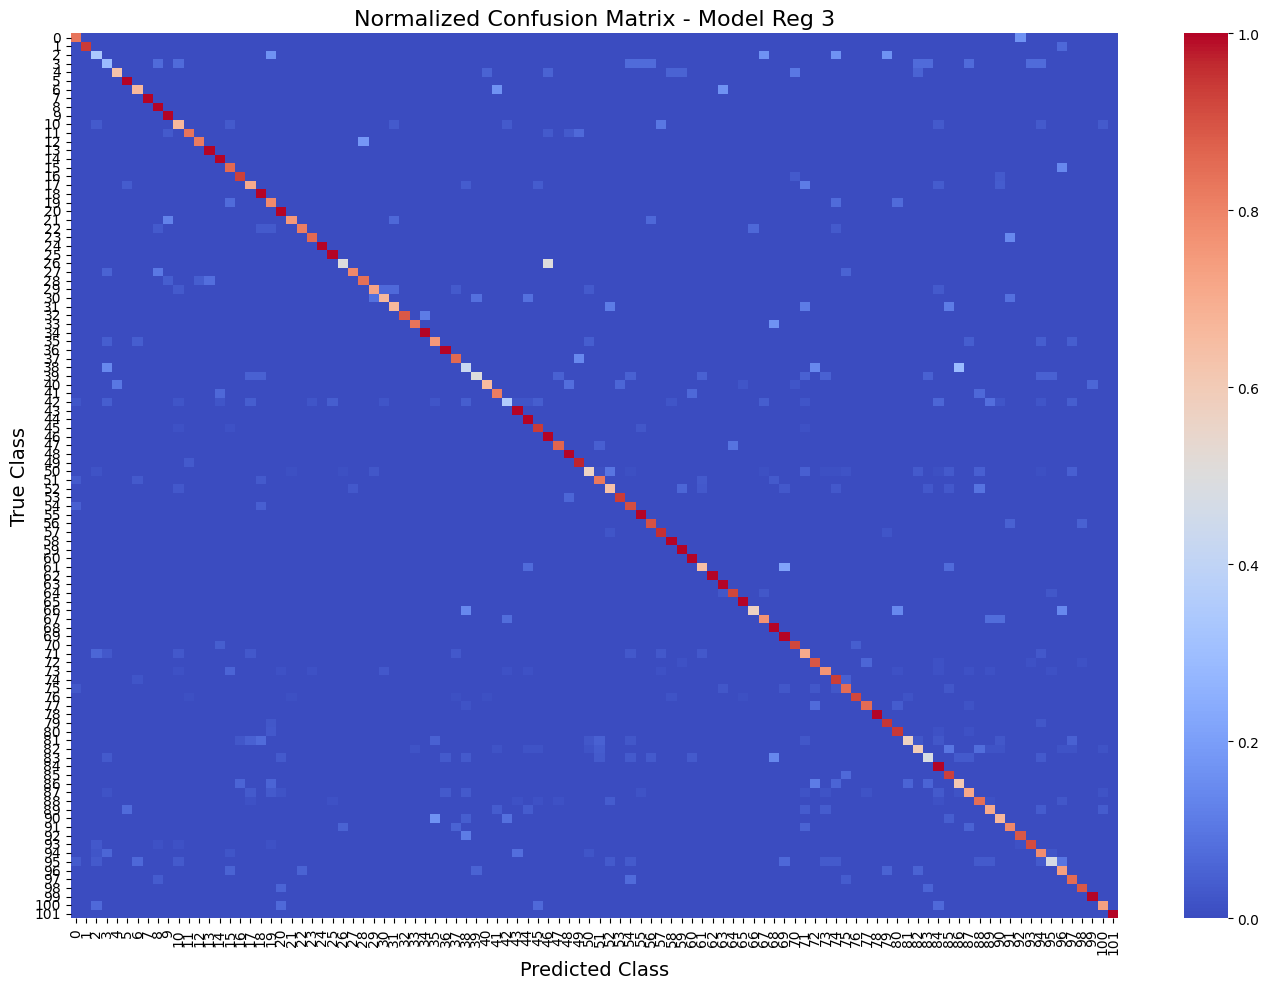

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.50      0.83      0.62         6
     Class 1       1.00      0.94      0.97        16
     Class 2       0.17      0.33      0.22         6
     Class 3       0.27      0.29      0.28        14
     Class 4       0.71      0.63      0.67        19
     Class 5       0.75      1.00      0.86         9
     Class 6       0.44      0.67      0.53         6
     Class 7       1.00      1.00      1.00        29
     Class 8       0.60      1.00      0.75         9
     Class 9       0.69      1.00      0.82         9
    Class 10       0.69      0.67      0.68        30
    Class 11       0.93      0.83      0.88        30
    Class 12       0.90      0.82      0.86        11
    Class 13       0.83      1.00      0.91        10
    Class 14       0.79      1.00      0.88        11
    Class 15       0.40      0.86      0.55         7
    Class 16       0.93      0.93      0.93        29
    

In [49]:
# Compute predictions and true labels for model_reg_3
y_true, y_pred = [], []

for images, labels in test_ds:
    preds = model_reg_3.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true, y_pred = np.array(y_true), np.array(y_pred)

# Check unique classes in true labels and predictions
print("Unique classes in test data:", np.unique(y_true))
print("Unique classes in predictions:", np.unique(y_pred))
print(f"Total defined classes: {num_classes}")

# Generate Confusion Matrix
unique_classes = np.unique(y_true.tolist() + y_pred.tolist())
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
plt.figure(figsize=(14, 10))
sns.heatmap(cm_normalized, annot=False, cmap="coolwarm", cbar=True, xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)
plt.title("Normalized Confusion Matrix - Model Reg 3", fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("confusion_matrix_model_reg_3.pdf")
plt.show()

# Generate Classification Report
report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in unique_classes])
print("Classification Report:")
print(report)

# Compute Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}")

# Check for missing classes in predictions
missing_classes = set(range(num_classes)) - set(np.unique(y_pred))
if missing_classes:
    print(f"Warning: The following classes were never predicted by the model: {missing_classes}")

## 6. Train, Validation and Test division and Preprocessing With Data Augmentation



This section creates a copy of the original dataset (`labels_df`) for data augmentation, adjusting the class indices to be zero-based. It verifies the number of unique labels and ensures that they range from 0 to 101.


In [140]:
# Create a new copy of the dataframe for Data Augmentation

labels_df_aug['Category'] = labels_df_aug['Category'] - 1  # Zero-based indexing

# Verify labels
print("Unique labels after conversion:", np.unique(labels_df_aug['Category']))
assert labels_df_aug['Category'].min() == 0, "Error: Labels must start from 0!"
assert labels_df_aug['Category'].max() == 101, "Error: Labels must go up to 101!"

# Image paths
image_paths_aug = labels_df_aug['Image'].apply(lambda x: os.path.join(extracted_images_dir, x)).values
labels_aug = labels_df_aug['Category'].values

# Verify the number of classes
num_classes_aug = len(np.unique(labels_aug))
print(f"Total number of classes (Augmented): {num_classes_aug}")

Unique labels after conversion: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101]
Total number of classes (Augmented): 102


Defines `apply_augmentation(image)`, which applies various transformations such as:



*   Random horizontal flipping
*   Random rotation
*   Brightness and contrast adjustments
*   Ensuring pixel values remain in the valid range





In [53]:
# Function to apply Data Augmentation
def apply_augmentation(image):
    """Apply a series of augmentations to create a new image"""
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)

    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random brightness
    image = tf.image.random_brightness(image, 0.2)

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Ensure values stay in [0, 1] range
    image = tf.clip_by_value(image, 0, 1)

    return image

# Function to preprocess image and create multiple augmented versions
def preprocess_with_augmentation(image_path, label, num_augmentations=3):
    """
    Preprocess image and create multiple augmented versions.
    Returns the original and num_augmentations augmented versions.
    """
    # Get original preprocessed image
    image, label = preprocess_image(image_path, label)

    # List to store all versions (starting with original)
    images = [image]
    labels = [label]

    # Create augmented versions
    for _ in range(num_augmentations):
        aug_image = apply_augmentation(image)
        images.append(aug_image)
        labels.append(label)

    return images, labels




A dataset is created where each image undergoes augmentation before being converted into a TensorFlow dataset.

In [54]:
# Function to create TensorFlow dataset with Data Augmentation
def df_to_augmented_dataset(df, batch_size=32, shuffle=True, augmentations_per_image=3):
    image_paths = df["Image"].apply(lambda x: os.path.join(extracted_images_dir, x)).values
    labels = df["Category"].values

    # Create lists for augmented data
    all_images = []
    all_labels = []

    # Process each image and its augmentations
    for path, label in zip(image_paths, labels):
        images, labels = preprocess_with_augmentation(path, label, augmentations_per_image)
        all_images.extend(images)
        all_labels.extend(labels)

    # Convert to tensors
    all_images = tf.stack(all_images)
    all_labels = tf.stack(all_labels)

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((all_images, all_labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(all_images))

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


The dataset is divided into training, validation, and test sets, ensuring that each class has 28 images for training, while the remaining images are split evenly between validation and test sets.

The processed data is converted into TensorFlow datasets (`train_ds_aug`, `val_ds_aug`, `test_ds_aug`) to be used for model training.






In [55]:
# Number of images per class
train_per_class_aug = 28

# Create lists for augmented datasets
train_list_aug, val_list_aug, test_list_aug = [], [], []

# Group by category
for category, group in labels_df_aug.groupby("Category"):
    group = group.sample(frac=1, random_state=42).reset_index(drop=True)
    train_list_aug.append(group[:train_per_class_aug])
    remaining = group[train_per_class_aug:]
    val_size_aug = len(remaining) // 2
    val_list_aug.append(remaining[:val_size_aug])
    test_list_aug.append(remaining[val_size_aug:])

# Merge datasets
train_df_aug = pd.concat(train_list_aug).reset_index(drop=True)
val_df_aug = pd.concat(val_list_aug).reset_index(drop=True)
test_df_aug = pd.concat(test_list_aug).reset_index(drop=True)

# Dataset check
print(f"Train set (Augmented): {len(train_df_aug)} images")
print(f"Augmented training images: {len(train_df_aug) * 4}")  # Original + 3 augmentations
print(f"Validation set (Augmented): {len(val_df_aug)} images")
print(f"Test set (Augmented): {len(test_df_aug)} images")

# Creating Augmented Datasets
batch_size = 32
train_ds_aug = df_to_augmented_dataset(train_df_aug, batch_size=batch_size, shuffle=True, augmentations_per_image=3)
val_ds_aug = df_to_dataset(val_df_aug, batch_size=batch_size, shuffle=False)
test_ds_aug = df_to_dataset(test_df_aug, batch_size=batch_size, shuffle=False)

print("Augmented datasets successfully created!")

Train set (Augmented): 2856 images
Augmented training images: 11424
Validation set (Augmented): 2642 images
Test set (Augmented): 2691 images
Augmented datasets successfully created!


A random image is selected from train_df_aug, and its original and augmented versions are displayed. The visualization is saved as a PDF file.

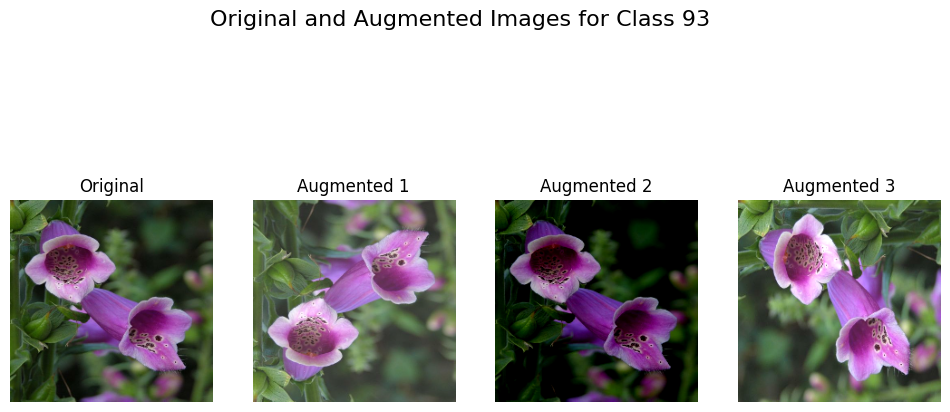

Augmentations saved locally in: /content/augmentations_colab.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
def visualize_and_save_augmentations_colab(df, augmentations_per_image=3, save_path="/content/augmentations_colab.pdf"):
    """
    Selects a random image from the dataset, displays its original and augmented versions,
    and saves the result in a PDF in the local directory.
    """
    # Select a random image from the dataset
    random_index = random.randint(0, len(df) - 1)
    image_path = os.path.join(extracted_images_dir, df.iloc[random_index]["Image"])
    label = df.iloc[random_index]["Category"]

    # Preprocess the original image
    original_image, _ = preprocess_image(image_path, label)

    # Generate augmented versions
    augmented_images = [apply_augmentation(original_image) for _ in range(augmentations_per_image)]

    # Create a PDF file to save the visualizations
    with PdfPages(save_path) as pdf:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f"Original and Augmented Images for Class {label}", fontsize=16)

        # Show the original image
        plt.subplot(1, augmentations_per_image + 1, 1)
        plt.imshow(original_image)
        plt.axis("off")
        plt.title("Original")

        # Show augmented images
        for i, aug_img in enumerate(augmented_images, start=2):
            plt.subplot(1, augmentations_per_image + 1, i)
            plt.imshow(aug_img)
            plt.axis("off")
            plt.title(f"Augmented {i-1}")

        # Save the plot to the PDF
        pdf.savefig()
        plt.show()  # Display the images in Colab
        plt.close()

    print(f"Augmentations saved locally in: {save_path}")

# Call the function to visualize and save augmentations
visualize_and_save_augmentations_colab(train_df_aug, augmentations_per_image=3, save_path="/content/augmentations_colab.pdf")

# Optional: Download the saved PDF
from google.colab import files
files.download("/content/augmentations_colab.pdf")




## 7. Defining Model With Data Augmentation

### 7.1 MobileNetV2 With Data Augmentation Base Model

First we try the base model with the data augmentation without any regularitazion.

In [58]:
# Add custom layers
model_aug = tf.keras.Sequential([
    pretrained_layer,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes_aug, activation='softmax')  # Adjusted for augmented dataset
])

# Compile the model
model_aug.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for early stopping
early_stopping_aug = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Print model summary
model_aug.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 102)                 │         130,662 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,388,646 (9.11 MB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [59]:
# Training the model with augmented dataset
history_aug = model_aug.fit(
    train_ds_aug,
    epochs=20,
    validation_data=val_ds_aug,
    callbacks=[early_stopping_aug],
)


Epoch 1/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.5071 - loss: 2.4370 - val_accuracy: 0.8195 - val_loss: 0.7895
Epoch 2/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9519 - loss: 0.3400 - val_accuracy: 0.8467 - val_loss: 0.6092
Epoch 3/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9863 - loss: 0.1611 - val_accuracy: 0.8664 - val_loss: 0.5352
Epoch 4/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9963 - loss: 0.0935 - val_accuracy: 0.8762 - val_loss: 0.4914
Epoch 5/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9990 - loss: 0.0555 - val_accuracy: 0.8777 - val_loss: 0.4670
Epoch 6/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9998 - loss: 0.0401 - val_accuracy: 0.8774 - val_loss: 0.4590
Epoch 7/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9998 - loss: 0.0284 - val_accuracy: 0.8793 - val_loss: 0.4587
Epoch 8/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 1.0000 - loss: 0.0215 - val_acc

Compared to the base model we reach a better accuracy on test set

In [60]:
# Accuracy on test set
test_loss_aug, test_accuracy_aug = model_aug.evaluate(test_ds_aug)
print(f"Test Accuracy (Augmented): {test_accuracy_aug * 100:.2f}%")

#Calculate accuracy on the balanced test-set with 6 samples per class
test_loss, test_accuracy_equalsize = model_aug.evaluate(test_ds_equalsize)
print(f"Test Accuracy (on balanced test set): {test_accuracy_equalsize * 100:.2f}%")

# Save the model
model_aug.save("model_oxford102_augmentedV1.h5")

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8864 - loss: 0.4146
Test Accuracy (Augmented): 88.44%
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9032 - loss: 0.3543


Test Accuracy (on balanced test set): 89.05%


##### 6.1.1. Plotting train and validation accuracy/loss

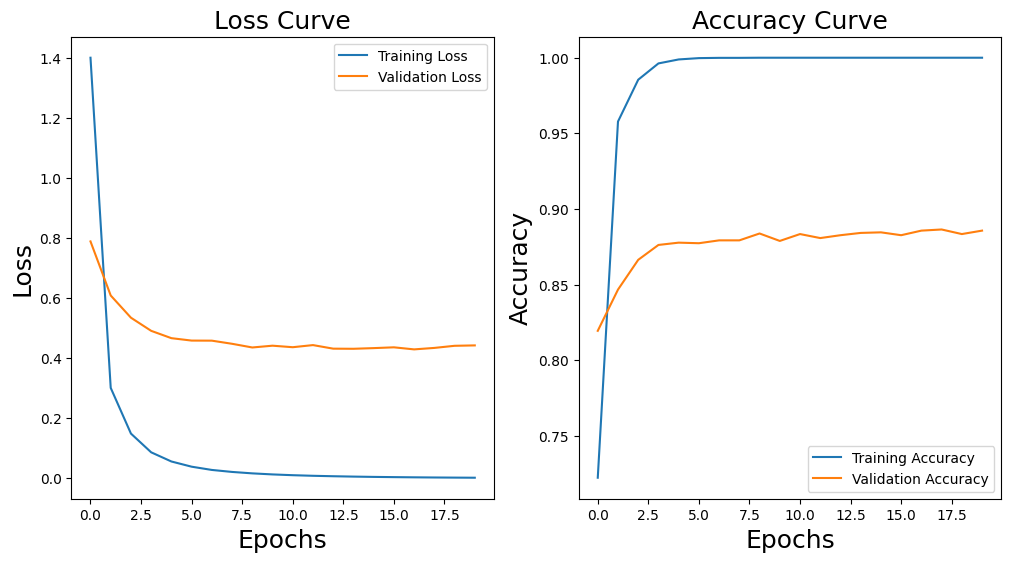

In [130]:
# Plot training history
plt.figure(figsize=(12, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history_aug.history['loss'], label='Training Loss')
plt.plot(history_aug.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend()

# Save the plot
plt.savefig("history_training_mobnetV2_augmented.pdf")
plt.show()

**Loss Curve**

Training Loss: The training loss decreases rapidly during the first few epochs, approaching zero as the model learns to fit the training data.

Validation Loss: The validation loss decreases initially but stabilizes after a few epochs. The gap between training and validation loss indicates some level of overfitting.

**Accuracy Curve**

Training Accuracy: The training accuracy increases rapidly, reaching 100% by epoch 5, showing the model's excellent performance on the training set.

Validation Accuracy: The validation accuracy improves steadily but stabilizes around 90%. The gap between training and validation accuracy compared to the non-augmented version suggests that data augmentation doesn't reduce overfitting.

##### 6.1.2 Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━

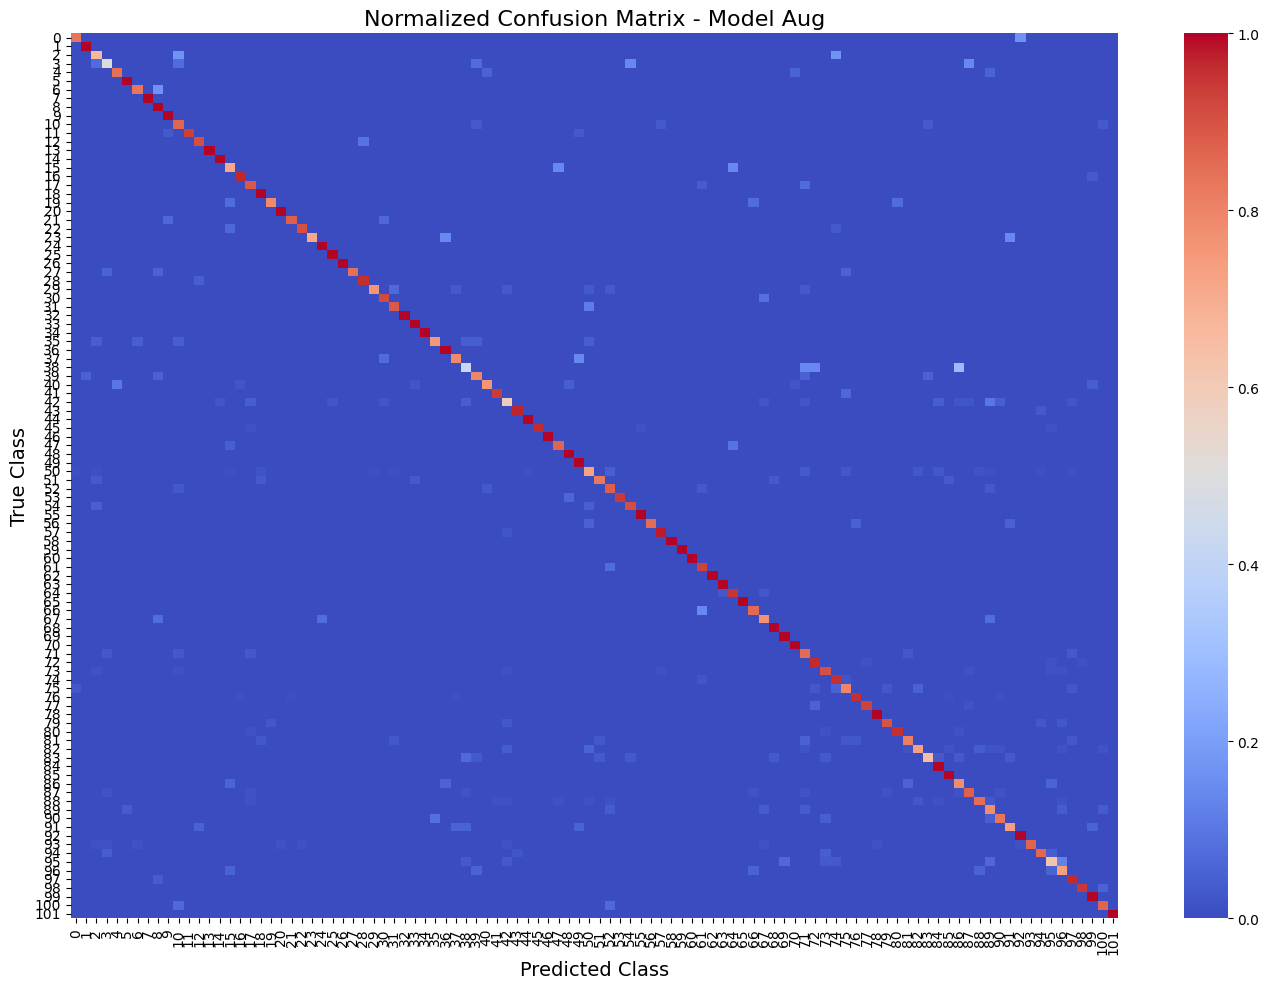

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.71      0.83      0.77         6
     Class 1       0.94      1.00      0.97        16
     Class 2       0.36      0.67      0.47         6
     Class 3       0.54      0.50      0.52        14
     Class 4       0.76      0.84      0.80        19
     Class 5       0.90      1.00      0.95         9
     Class 6       0.71      0.83      0.77         6
     Class 7       1.00      1.00      1.00        29
     Class 8       0.64      1.00      0.78         9
     Class 9       0.82      1.00      0.90         9
    Class 10       0.79      0.87      0.83        30
    Class 11       1.00      0.93      0.97        30
    Class 12       0.83      0.91      0.87        11
    Class 13       1.00      1.00      1.00        10
    Class 14       0.92      1.00      0.96        11
    Class 15       0.42      0.71      0.53         7
    Class 16       0.93      0.97      0.95        29
    

In [62]:
# Compute predictions and true labels for model_aug
y_true, y_pred = [], []

for images, labels in test_ds_aug:
    preds = model_aug.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true, y_pred = np.array(y_true), np.array(y_pred)

# Check unique classes in true labels and predictions
print("Unique classes in test data:", np.unique(y_true))
print("Unique classes in predictions:", np.unique(y_pred))
print(f"Total defined classes: {num_classes_aug}")

# Generate Confusion Matrix
unique_classes = np.unique(y_true.tolist() + y_pred.tolist())
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
plt.figure(figsize=(14, 10))
sns.heatmap(cm_normalized, annot=False, cmap="coolwarm", cbar=True, xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)
plt.title("Normalized Confusion Matrix - Model Aug", fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("confusion_matrix_model_aug.pdf")
plt.show()

# Generate Classification Report
report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in unique_classes])
print("Classification Report:")
print(report)

# Compute Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}")

# Check for missing classes in predictions
missing_classes = set(range(num_classes_aug)) - set(np.unique(y_pred))
if missing_classes:
    print(f"Warning: The following classes were never predicted by the model: {missing_classes}")

### 7.2 MobileNetV2 With Data Augmentation With Regularitazion


This model includes a fully connected dense layer with 256 neurons, activated by ReLU and regularized using L2 regularization (0.01) to minimize overfitting. A dropout layer with a 30% rate is added to reduce overfitting. The final layer is a fully connected softmax layer, outputting probabilities for each class based on the dataset's num_classes.

In [63]:
# Build the model
model_reg_aug_1 = tf.keras.Sequential([
    pretrained_layer,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_reg_aug_1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback for Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Print the model summary
model_reg_aug_1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 102)                 │          26,214 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,612,134 (9.96 MB)

 Trainable params: 354,150 (1.35 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [64]:
# Train the model
history_reg_aug_1 = model_reg_aug_1.fit(
    train_ds,
    epochs=40,
    validation_data=val_ds,
    callbacks=[early_stopping],
)

Epoch 1/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 198ms/step - accuracy: 0.0155 - loss: 8.9192 - val_accuracy: 0.0693 - val_loss: 8.1762
Epoch 2/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1017 - loss: 7.9470 - val_accuracy: 0.1843 - val_loss: 7.3793
Epoch 3/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.2262 - loss: 7.1269 - val_accuracy: 0.3467 - val_loss: 6.5729
Epoch 4/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.3521 - loss: 6.2863 - val_accuracy: 0.4833 - val_loss: 5.7938
Epoch 5/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.4620 - loss: 5.5411 - val_accuracy: 0.5901 - val_loss: 5.1732
Epoch 6/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5199 - loss: 5.0273 - val_accuracy: 0.6476 - val_loss: 4.6814
Epoch 7/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5951 - loss: 4.5315 - val_accuracy: 0.6923 - val_loss: 4.2979
Epoch 8/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6442 - loss: 4.1512 - val_accuracy: 0.7192 -

In [65]:
# Accuracy on test set
test_loss, test_accuracy = model_reg_aug_1.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Calculate accuracy on the balanced test-set with 6 samples per class
test_loss, test_accuracy_equalsize = model_reg_aug_1.evaluate(test_ds_equalsize)
print(f"Test Accuracy (on balanced test set): {test_accuracy_equalsize * 100:.2f}%")

# Save the trained model
model_reg_aug_1.save("model_reg_aug_1.h5")


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8362 - loss: 1.4620
Test Accuracy: 85.43%
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.8633 - loss: 1.3809


Test Accuracy (on balanced test set): 86.93%


##### 6.2.1. Plotting train and validation accuracy/loss

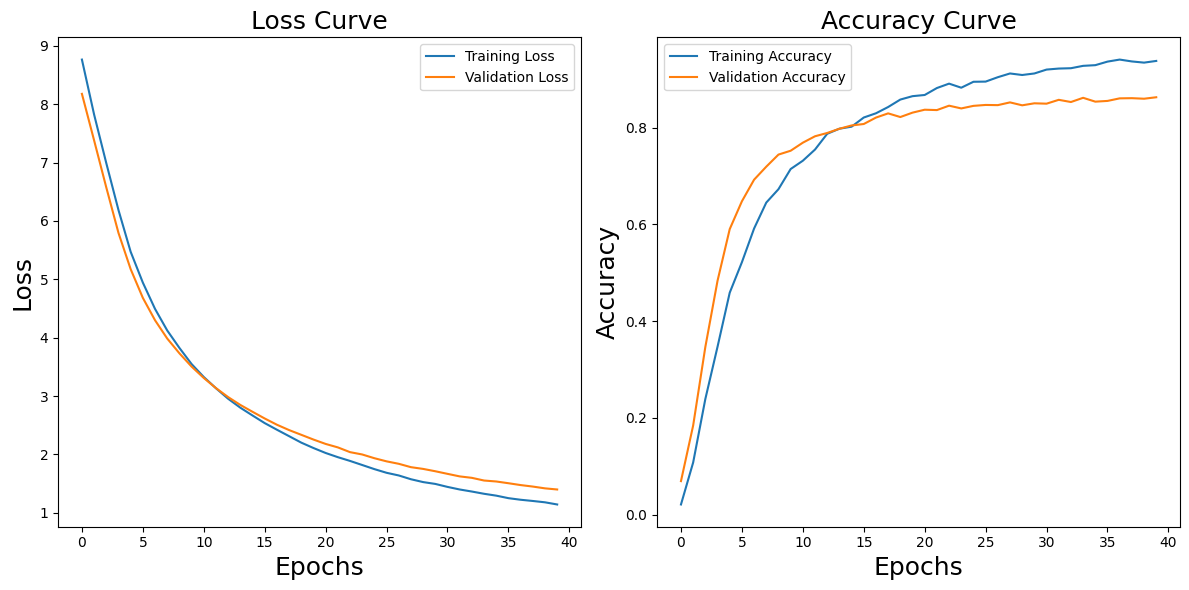

In [131]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history_reg_aug_1.history['loss'], label='Training Loss')
plt.plot(history_reg_aug_1.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history_reg_aug_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_reg_aug_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend()

plt.tight_layout()
plt.savefig("history_training_model_reg_aug_1.pdf")
plt.show()


**Loss Curve**

The training loss decreases steadily over the epochs, showing the model's ability to learn effectively from the training data.

The validation loss closely follows the training loss with a minimal gap, indicating that the model is not overfitting significantly and generalizes in a good way to unseen data.

**Accuracy Curve**

The training accuracy improves consistently, reaching a high value as the epochs progress.

The validation accuracy also increases steadily, though it converges slightly lower than the training accuracy, suggesting good generalization. The relatively small gap between training and validation accuracy further supports the observation that the model benefits from data augmentation and regularization, reducing overfitting.

##### 6.2.2 Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━

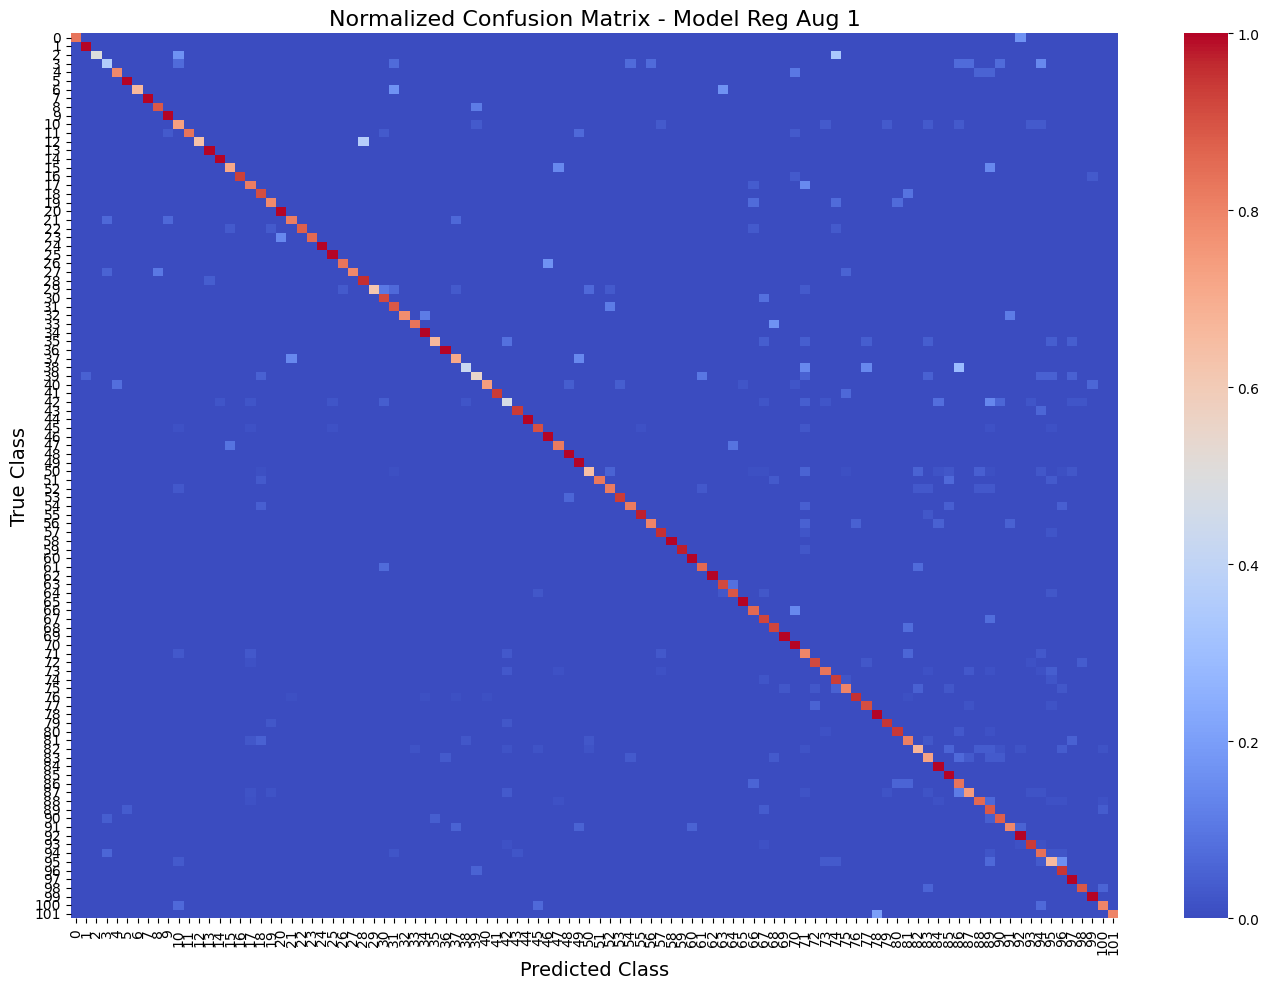

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.83      0.91         6
     Class 1       0.94      1.00      0.97        16
     Class 2       1.00      0.50      0.67         6
     Class 3       0.45      0.36      0.40        14
     Class 4       0.79      0.79      0.79        19
     Class 5       0.90      1.00      0.95         9
     Class 6       1.00      0.67      0.80         6
     Class 7       1.00      1.00      1.00        29
     Class 8       0.80      0.89      0.84         9
     Class 9       0.82      1.00      0.90         9
    Class 10       0.76      0.73      0.75        30
    Class 11       1.00      0.83      0.91        30
    Class 12       1.00      0.64      0.78        11
    Class 13       0.91      1.00      0.95        10
    Class 14       0.92      1.00      0.96        11
    Class 15       0.62      0.71      0.67         7
    Class 16       1.00      0.93      0.96        29
    

In [67]:
# Compute predictions and true labels for model_reg_aug_1
y_true, y_pred = [], []

for images, labels in test_ds_aug:
    preds = model_reg_aug_1.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true, y_pred = np.array(y_true), np.array(y_pred)

# Check unique classes in true labels and predictions
print("Unique classes in test data:", np.unique(y_true))
print("Unique classes in predictions:", np.unique(y_pred))
print(f"Total defined classes: {num_classes}")

# Generate Confusion Matrix
unique_classes = np.unique(y_true.tolist() + y_pred.tolist())
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
plt.figure(figsize=(14, 10))
sns.heatmap(cm_normalized, annot=False, cmap="coolwarm", cbar=True, xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)
plt.title("Normalized Confusion Matrix - Model Reg Aug 1", fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("confusion_matrix_model_reg_aug_1.pdf")
plt.show()

# Generate Classification Report
report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in unique_classes])
print("Classification Report:")
print(report)

# Compute Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}")

# Check for missing classes in predictions
missing_classes = set(range(num_classes)) - set(np.unique(y_pred))
if missing_classes:
    print(f"Warning: The following classes were never predicted by the model: {missing_classes}")


### 7.3 MobileNetV2 With Data Augmentation With Regularitazion

To reduce overfitting, Dropout is implemented at two stages: a dropout rate of 30% is applied before the first dense layer, and another dropout rate of 20% is applied after. The dense layer with 256 neurons utilizes the ReLU activation function and includes an L2 regularization term of 0.02, ensuring penalization of large weights.

The output layer consists of a dense layer with a softmax activation function, corresponding to the number of augmented dataset classes (num_classes_aug), also employing L2 regularization to further mitigate overfitting.

In [68]:
# Define the model for augmented dataset
model_reg_aug_2 = tf.keras.Sequential([
    pretrained_layer,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),  # First dropout
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.02)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),  # Second dropout
    layers.Dense(num_classes_aug, activation='softmax', kernel_regularizer=l2(0.02))
])

# Compile the model
model_reg_aug_2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping_aug_2 = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    min_delta=0.001
)

# Model summary
model_reg_aug_2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 102)                 │          26,214 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,618,278 (9.99 MB)

 Trainable params: 357,222 (1.36 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

In [69]:
# Train the model with the new augmented dataset
history_reg_aug_2 = model_reg_aug_2.fit(
    train_ds_aug,
    epochs=30,
    validation_data=val_ds_aug,
    callbacks=[early_stopping_aug_2]
)


Epoch 1/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.0712 - loss: 15.4929 - val_accuracy: 0.4587 - val_loss: 12.1824
Epoch 2/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.4489 - loss: 11.4931 - val_accuracy: 0.6571 - val_loss: 9.5569
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6717 - loss: 8.9977 - val_accuracy: 0.7415 - val_loss: 7.6421
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7728 - loss: 7.1493 - val_accuracy: 0.7877 - val_loss: 6.1593
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8442 - loss: 5.6781 - val_accuracy: 0.8259 - val_loss: 4.9717
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8875 - loss: 4.5167 - val_accuracy: 0.8429 - val_loss: 4.0594
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9158 - loss: 3.6266 - val_accuracy: 0.8516 - val_loss: 3.3617
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9384 - loss: 2.9493 - val_

In [70]:
# Accuracy on test set
test_loss_aug_2, test_accuracy_aug_2 = model_reg_aug_2.evaluate(test_ds_aug)
print(f"Test Accuracy (Augmented): {test_accuracy_aug_2 * 100:.2f}%")

# Calculate accuracy on the balanced test-set with 6 samples per class
test_loss, test_accuracy_equalsize = model_reg_aug_2.evaluate(test_ds_equalsize)
print(f"Test Accuracy (on balanced test set): {test_accuracy_equalsize * 100:.2f}%")

#  Save the model
model_reg_aug_2.save("model_reg_aug_2_oxford102.h5")



85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8763 - loss: 1.1245
Test Accuracy (Augmented): 87.55%
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.8909 - loss: 1.0885


Test Accuracy (on balanced test set): 89.22%


##### 6.3.1. Plotting train and validation accuracy/loss

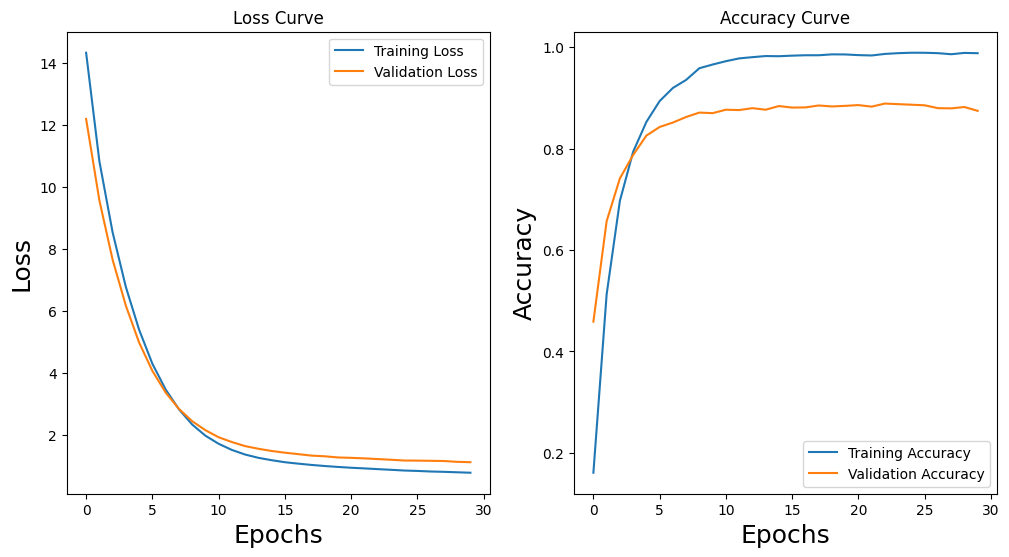

In [72]:
#Plot training history
plt.figure(figsize=(12, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history_reg_aug_2.history['loss'], label='Training Loss')
plt.plot(history_reg_aug_2.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history_reg_aug_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_reg_aug_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend()

# Save the plot
plt.savefig("history_training_mobnetV_augV2.pdf")
plt.show()

**Loss Curve**

The training loss shows a consistent decline over the epochs, reaching very low values, which indicates the model is fitting the training data very well.

The validation loss decreases initially but starts to stabilize around a higher value than the training loss. This divergence, especially noticeable after a few epochs, is a clear indication of overfitting. The model is focusing on the training data at the expense of generalization.

**Accuracy Curve**

The training accuracy climbs rapidly, approaching 100% by the end of the training, demonstrating excellent performance on the training set.

The validation accuracy reaches a plateau significantly lower than the training accuracy, around 85-90%. This increasing gap between training and validation accuracy further highlights the overfitting issue. The model struggles to generalize to unseen data, and it memorizes patterns specific to the training set.

##### 6.3.2 Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━

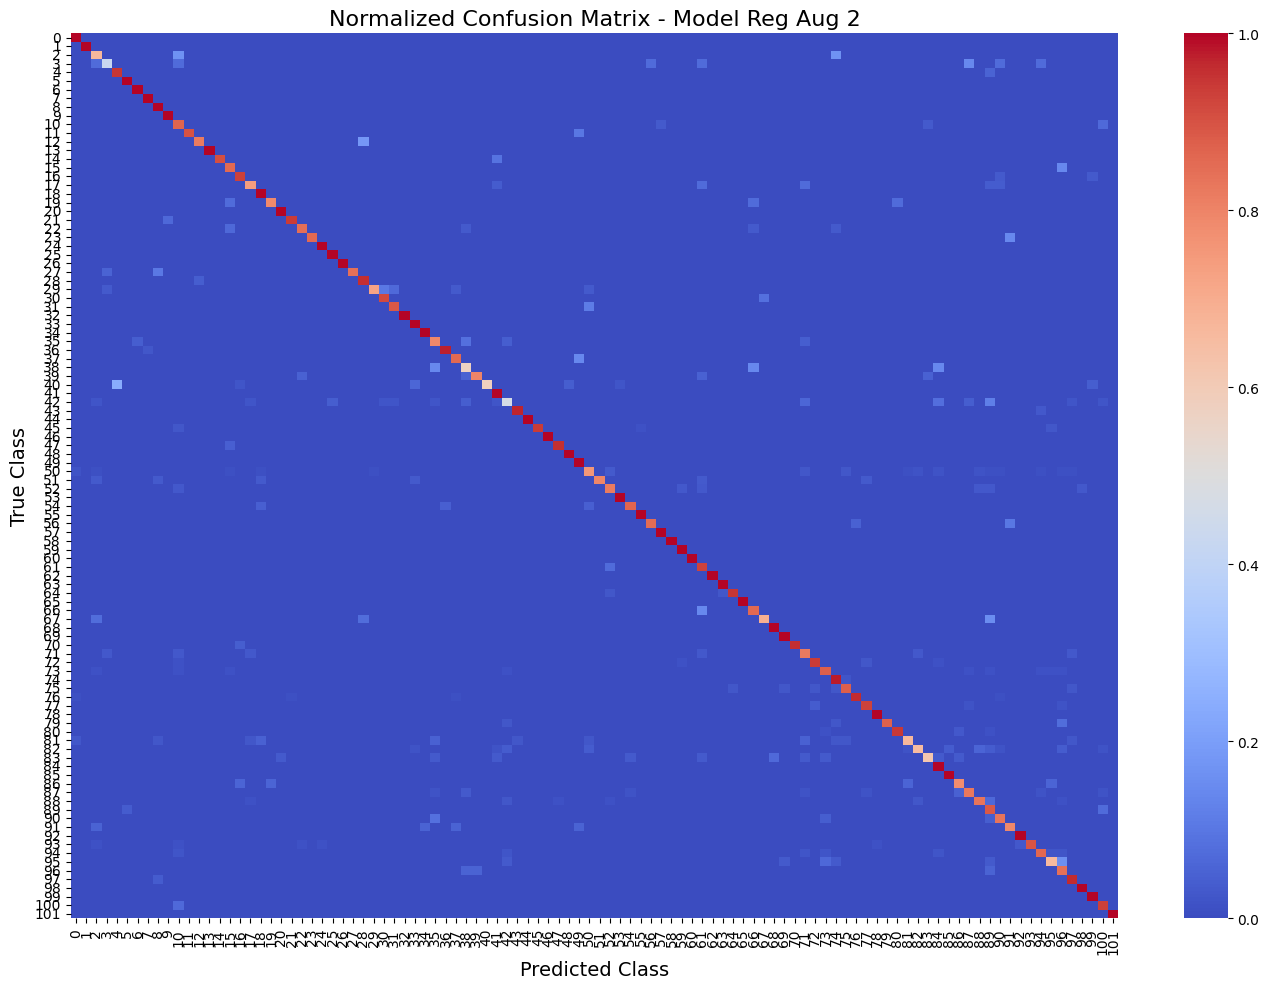

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.60      1.00      0.75         6
     Class 1       1.00      1.00      1.00        16
     Class 2       0.33      0.67      0.44         6
     Class 3       0.67      0.43      0.52        14
     Class 4       0.60      0.95      0.73        19
     Class 5       0.90      1.00      0.95         9
     Class 6       0.86      1.00      0.92         6
     Class 7       0.97      1.00      0.98        29
     Class 8       0.64      1.00      0.78         9
     Class 9       0.90      1.00      0.95         9
    Class 10       0.70      0.87      0.78        30
    Class 11       1.00      0.90      0.95        30
    Class 12       0.90      0.82      0.86        11
    Class 13       1.00      1.00      1.00        10
    Class 14       1.00      0.91      0.95        11
    Class 15       0.50      0.86      0.63         7
    Class 16       0.90      0.93      0.92        29
    

In [73]:
# Compute predictions and true labels for model_reg_aug_2
y_true, y_pred = [], []

for images, labels in test_ds_aug:
    preds = model_reg_aug_2.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true, y_pred = np.array(y_true), np.array(y_pred)

# Check unique classes in true labels and predictions
print("Unique classes in test data:", np.unique(y_true))
print("Unique classes in predictions:", np.unique(y_pred))
print(f"Total defined classes: {num_classes_aug}")

# Generate Confusion Matrix
unique_classes = np.unique(y_true.tolist() + y_pred.tolist())
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
plt.figure(figsize=(14, 10))
sns.heatmap(cm_normalized, annot=False, cmap="coolwarm", cbar=True, xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)
plt.title("Normalized Confusion Matrix - Model Reg Aug 2", fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("confusion_matrix_model_reg_aug_2.pdf")
plt.show()

# Generate Classification Report
report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in unique_classes])
print("Classification Report:")
print(report)

# Compute Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}")

# Check for missing classes in predictions
missing_classes = set(range(num_classes_aug)) - set(np.unique(y_pred))
if missing_classes:
    print(f"Warning: The following classes were never predicted by the model: {missing_classes}")


### 7.4 MobileNetV2 With Data Augmentation With Regularitazion

The main differences in `model_reg_aug_3` are the increased dropout rates (set to 0.4), which provide stronger regularization, and a reduced hidden layer size with 128 units instead of 256. Batch normalization is applied before and after the dense layers to stabilize training, and the L2 regularization is increased to 0.03 for better control of overfitting.

In [74]:
# Build the model
model_reg_aug_3 = tf.keras.Sequential([
    pretrained_layer,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.03)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.03))
])

# Compile the model
model_reg_aug_3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback for Early Stopping
early_stopping_aug_3 = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    min_delta=0.001
)

# Print the model summary
model_reg_aug_3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 102)                 │          13,158 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,440,742 (9.31 MB)

 Trainable params: 179,942 (702.90 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

In [75]:
# Train the model
history_reg_aug_3 = model_reg_aug_3.fit(
    train_ds_aug,
    epochs=25,
    validation_data=val_ds_aug,
    callbacks=[early_stopping_aug_3]
)

Epoch 1/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.0231 - loss: 14.8809 - val_accuracy: 0.2475 - val_loss: 12.0255
Epoch 2/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.1686 - loss: 11.6367 - val_accuracy: 0.4618 - val_loss: 9.6727
Epoch 3/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.3392 - loss: 9.3546 - val_accuracy: 0.5908 - val_loss: 7.9330
Epoch 4/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.4853 - loss: 7.6567 - val_accuracy: 0.6673 - val_loss: 6.5681
Epoch 5/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5876 - loss: 6.3272 - val_accuracy: 0.7222 - val_loss: 5.4956
Epoch 6/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6496 - loss: 5.3196 - val_accuracy: 0.7585 - val_loss: 4.6853
Epoch 7/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7153 - loss: 4.5062 - val_accuracy: 0.7911 - val_loss: 4.0345
Epoch 8/25
357/357 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7633 - loss: 3.8613 - val_

In [76]:
# Save the trained model
model_reg_aug_3.save("model_reg_aug_3.h5")

# Evaluate the model on the test set
test_loss_aug_3, test_accuracy_aug_3 = model_reg_aug_3.evaluate(test_ds_aug)
print(f"Test Accuracy (Augmented Model 3): {test_accuracy_aug_3 * 100:.2f}%")

# Calculate accuracy on the balanced test-set with 6 samples per class
test_loss, test_accuracy_equalsize = model_reg_aug_2.evaluate(test_ds_equalsize)
print(f"Test Accuracy (on balanced test set): {test_accuracy_equalsize * 100:.2f}%")

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8639 - loss: 1.7285
Test Accuracy (Augmented Model 3): 87.07%
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8974 - loss: 1.0941
Test Accuracy (on balanced test set): 89.22%


##### 6.4.1. Plotting train and validation accuracy/loss

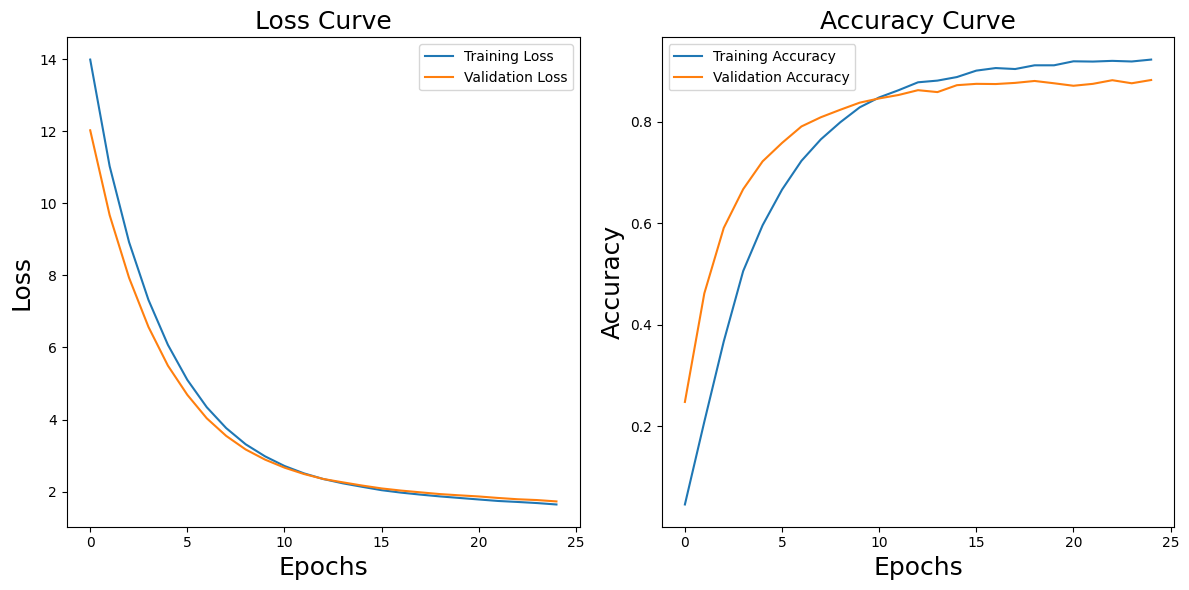

In [137]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 6))

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history_reg_aug_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_reg_aug_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve', fontsize=18)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.legend()

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history_reg_aug_3.history['loss'], label='Training Loss')
plt.plot(history_reg_aug_3.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve', fontsize=18)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.legend()

plt.tight_layout()
plt.savefig("history_training_model_reg_aug_3.pdf")
plt.show()

**Loss Curve**

The training loss decreases consistently across epochs, with the validation loss closely following it. The minimal gap between the two curves indicates a significant reduction in overfitting compared to earlier models, showcasing better generalization to unseen data.

**Accuracy Curve **

The training accuracy steadily improves and stabilizes, while the validation accuracy closely follows with only a slight gap. This alignment between training and validation accuracy further highlights the model's enhanced ability to generalize effectively. Overfitting has been noticeably reduced in this configuration.

##### 6.4.2 Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━

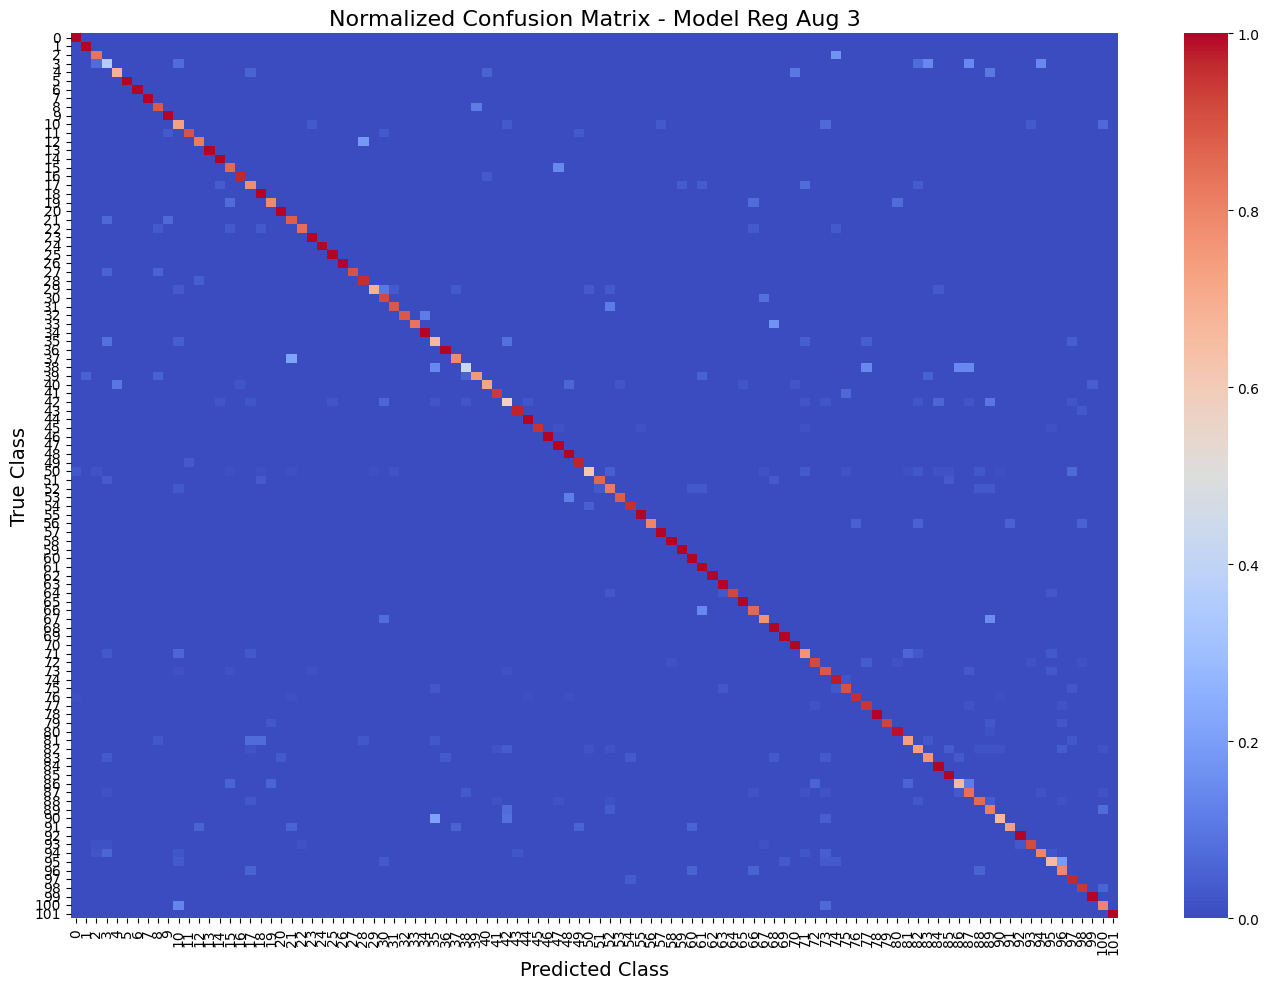

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.60      1.00      0.75         6
     Class 1       0.94      1.00      0.97        16
     Class 2       0.50      0.83      0.62         6
     Class 3       0.29      0.36      0.32        14
     Class 4       0.72      0.68      0.70        19
     Class 5       1.00      1.00      1.00         9
     Class 6       1.00      1.00      1.00         6
     Class 7       1.00      1.00      1.00        29
     Class 8       0.67      0.89      0.76         9
     Class 9       0.82      1.00      0.90         9
    Class 10       0.67      0.73      0.70        30
    Class 11       0.96      0.90      0.93        30
    Class 12       0.82      0.82      0.82        11
    Class 13       1.00      1.00      1.00        10
    Class 14       0.85      1.00      0.92        11
    Class 15       0.55      0.86      0.67         7
    Class 16       0.97      0.97      0.97        29
    

In [78]:
# Compute predictions and true labels for model_reg_aug_3
y_true, y_pred = [], []

for images, labels in test_ds_aug:
    preds = model_reg_aug_3.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true, y_pred = np.array(y_true), np.array(y_pred)

# Check unique classes in true labels and predictions
print("Unique classes in test data:", np.unique(y_true))
print("Unique classes in predictions:", np.unique(y_pred))
print(f"Total defined classes: {num_classes}")

# Generate Confusion Matrix
unique_classes = np.unique(y_true.tolist() + y_pred.tolist())
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
plt.figure(figsize=(14, 10))
sns.heatmap(cm_normalized, annot=False, cmap="coolwarm", cbar=True, xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)
plt.title("Normalized Confusion Matrix - Model Reg Aug 3", fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("confusion_matrix_model_reg_aug_3.pdf")
plt.show()

# Generate Classification Report
report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in unique_classes])
print("Classification Report:")
print(report)

# Compute Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}")

# Check for missing classes in predictions
missing_classes = set(range(num_classes)) - set(np.unique(y_pred))
if missing_classes:
    print(f"Warning: The following classes were never predicted by the model: {missing_classes}")
